In [1]:
import itertools
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm import tqdm
from scipy.stats import shapiro, norm

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, SeasonalExponentialSmoothing

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import arch
from arch import arch_model

import holidays

import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

warnings.filterwarnings("ignore")


In [2]:
processed_base = Path("/Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/processed")

for state in ["QLD", "NSW", "VIC", "SA", "TAS"]:
    p = processed_base / f"{state}_data_2018_2025.csv"
    print(state, "exists?", p.exists(), "→", p)

# Load (with dates parsed) using absolute paths
QLD_path = processed_base / "QLD_data_2018_2025.csv"
NSW_path = processed_base / "NSW_data_2018_2025.csv"
VIC_path = processed_base / "VIC_data_2018_2025.csv"
TAS_path = processed_base / "TAS_data_2018_2025.csv"
SA_path = processed_base / "SA_data_2018_2025.csv"

QLD_data = pd.read_csv(QLD_path, parse_dates=["SETTLEMENTDATE"])
NSW_data = pd.read_csv(NSW_path, parse_dates=["SETTLEMENTDATE"])
VIC_data = pd.read_csv(VIC_path, parse_dates=["SETTLEMENTDATE"])
TAS_data = pd.read_csv(TAS_path, parse_dates=["SETTLEMENTDATE"])
SA_data = pd.read_csv(SA_path, parse_dates=["SETTLEMENTDATE"])


QLD exists? True → /Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/processed/QLD_data_2018_2025.csv
NSW exists? True → /Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/processed/NSW_data_2018_2025.csv
VIC exists? True → /Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/processed/VIC_data_2018_2025.csv
SA exists? True → /Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/processed/SA_data_2018_2025.csv
TAS exists? True → /Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/processed/TAS_data_2018_2025.csv


# Data preprocessing

In [3]:
dataset_list = [("QLD_data", QLD_data), ("NSW_data", NSW_data), ("VIC_data", VIC_data), ("TAS_data", TAS_data), ("SA_data", SA_data)]
for name, data in dataset_list:
    print(f'{name} information{"-"*30}')
    data.info()
    print('\n')

QLD_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477840 entries, 0 to 477839
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          477840 non-null  object        
 1   SETTLEMENTDATE  477840 non-null  datetime64[ns]
 2   TOTALDEMAND     477840 non-null  float64       
 3   RRP             477840 non-null  float64       
 4   PERIODTYPE      477840 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 18.2+ MB


NSW_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476976 entries, 0 to 476975
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          476976 non-null  object        
 1   SETTLEMENTDATE  476976 non-null  datetime64[ns]
 2   TOTALDEMAND     

In [4]:
# when merging the data, some headers from other tables are included, hence we need to drop those rows
for data in [QLD_data, NSW_data, VIC_data, TAS_data, SA_data]:
    data.drop(data[data['REGION'] == 'REGION'].index, inplace=True)
    data.dropna(subset=['SETTLEMENTDATE'], inplace=True)

In [5]:
# convert date / hour columns to datetime format
for data in [QLD_data, NSW_data, VIC_data, TAS_data, SA_data]:
    data['SETTLEMENTDATE'] = pd.to_datetime(data['SETTLEMENTDATE'], format='mixed', dayfirst=True)

In [6]:
# convert totaldemand to numeric
for data in [QLD_data, NSW_data, VIC_data, TAS_data, SA_data]:
    data['TOTALDEMAND'] = pd.to_numeric(data['TOTALDEMAND'])

In [7]:
dataset_list = [("QLD_data", QLD_data), ("NSW_data", NSW_data), ("VIC_data", VIC_data), ("TAS_data", TAS_data), ("SA_data", SA_data)]
for name, data in dataset_list:
    print(f'{name} information{"-"*30}')
    data.info()
    print('\n')

QLD_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477840 entries, 0 to 477839
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          477840 non-null  object        
 1   SETTLEMENTDATE  477840 non-null  datetime64[ns]
 2   TOTALDEMAND     477840 non-null  float64       
 3   RRP             477840 non-null  float64       
 4   PERIODTYPE      477840 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 18.2+ MB


NSW_data information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476976 entries, 0 to 476975
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          476976 non-null  object        
 1   SETTLEMENTDATE  476976 non-null  datetime64[ns]
 2   TOTALDEMAND     

# Target variable (Total demand)

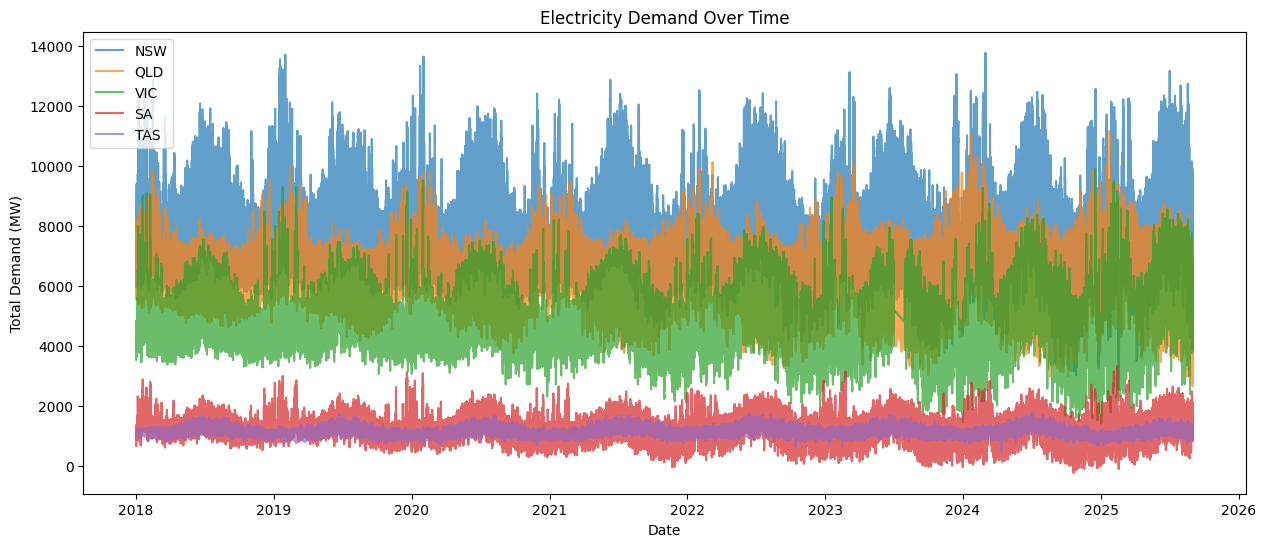

In [8]:
plt.figure(figsize=(15, 6))
plt.plot(NSW_data['SETTLEMENTDATE'], NSW_data['TOTALDEMAND'], label='NSW', alpha=0.7)
plt.plot(QLD_data['SETTLEMENTDATE'], QLD_data['TOTALDEMAND'], label='QLD', alpha=0.7)
plt.plot(VIC_data['SETTLEMENTDATE'], VIC_data['TOTALDEMAND'], label='VIC', alpha=0.7)
plt.plot(SA_data['SETTLEMENTDATE'], SA_data['TOTALDEMAND'], label='SA', alpha=0.7)
plt.plot(TAS_data['SETTLEMENTDATE'], TAS_data['TOTALDEMAND'], label='TAS', alpha=0.7)
plt.title('Electricity Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Total Demand (MW)')
plt.legend()
plt.show()

- SA and TAS are much smaller in terms of `totaldemand`

## Seasonality

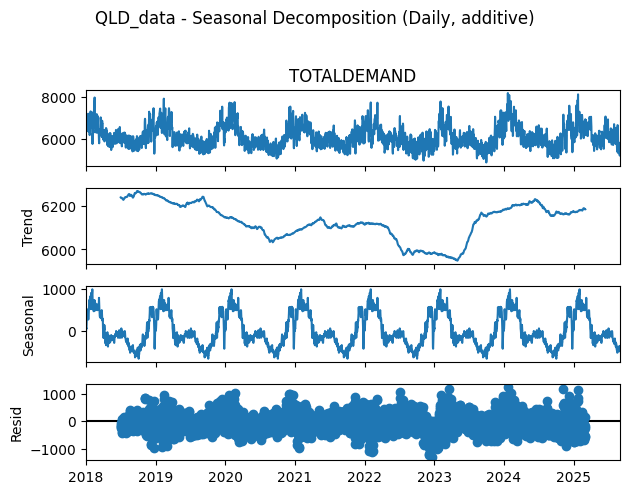

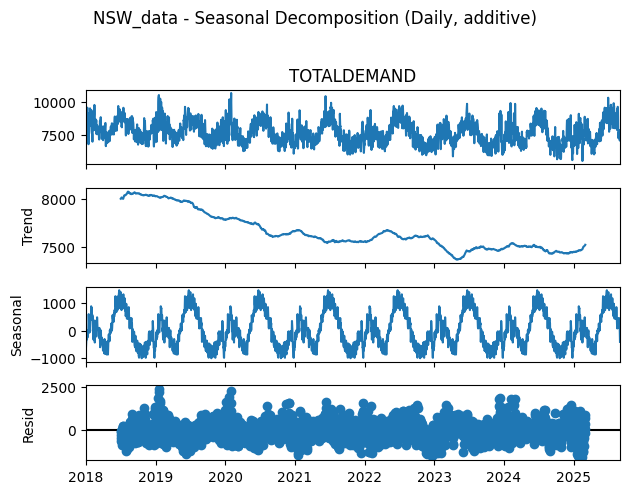

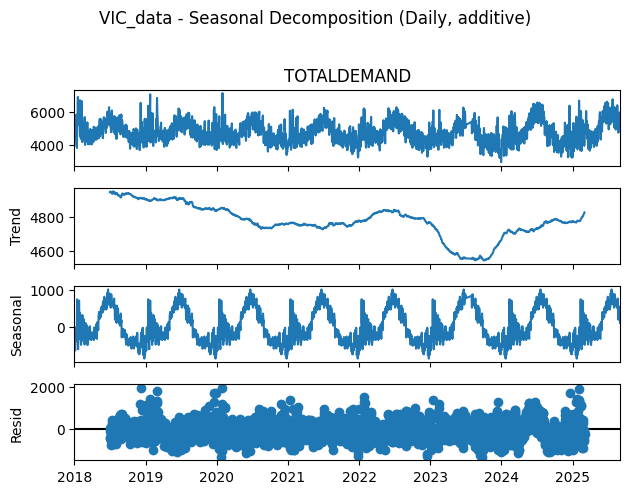

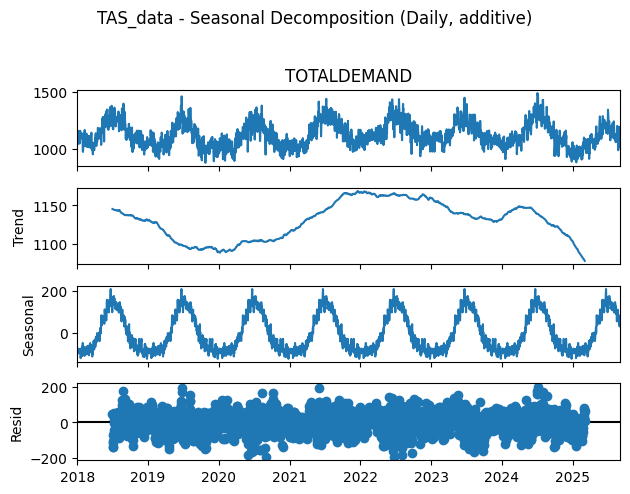

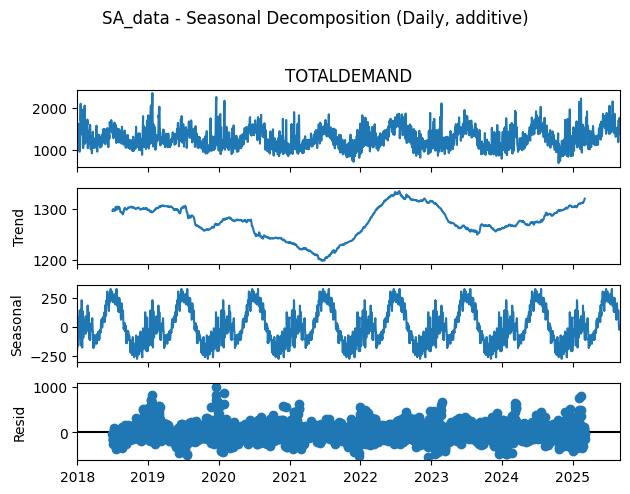

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

for name, df in dataset_list:
    df = df.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')

    # Resample to daily average
    daily_mean = df['TOTALDEMAND'].resample('D').mean().dropna()

    # Seasonal decomposition (yearly cycle = 365 days for daily data)
    res = seasonal_decompose(daily_mean, model='additive', period=365)

    # Use built-in plotting
    fig = res.plot()
    fig.suptitle(f"{name} - Seasonal Decomposition (Daily, additive)", y=1.02)
    plt.tight_layout()
    plt.show()


- Trend: NSW/QLD/VIC dip through 2020–22 then recover; TAS/SA show a gentler arc. That’s consistent with COVID effects + rooftop PV uptake shifting daytime demand.

- Seasonality: Strong, repeating cycles—both weekly and annual are evident. On daily data the weekly pattern is still present; your classical additive decomp (one period) captured mostly annual seasonality.

- Residuals: Still autocorrelated (bursts around heatwaves/holidays). That means a single-season additive model won’t fully explain the structure.

**Next steps that will improve things**
- Use **multiplicative seasonality in NSW/QLD.**

- Model multiple seasonalities (weekly=7 and annual≈365/366) with MSTL or TBATS/Prophet rather than a single-period classical decompose.

- Check residual diagnostics: ACF/PACF of residuals; Ljung–Box; seasonal strength metrics.

- Downstream models: SARIMA with seasonal difference at 7 and possibly 365, or Regression-with-ARIMA-errors including weather/holiday features.

## Freq dynamics

In [10]:
# We're taking only the totaldemand for time series modeling 
# resample the data to monthly frequency and calculate the mean total demand (monthly average)
NSW = NSW_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
QLD = QLD_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
VIC = VIC_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
TAS = TAS_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']
SA = SA_data.sort_values('SETTLEMENTDATE').set_index('SETTLEMENTDATE')['TOTALDEMAND']

NSW_m = (NSW.resample('M').sum() / 2).rename('NSW')
QLD_m = (QLD.resample('M').sum() / 2).rename('QLD')
VIC_m = (VIC.resample('M').sum() / 2).rename('VIC')
TAS_m = (TAS.resample('M').sum() / 2).rename('TAS')
SA_m  = (SA.resample('M').sum()  / 2).rename('SA')


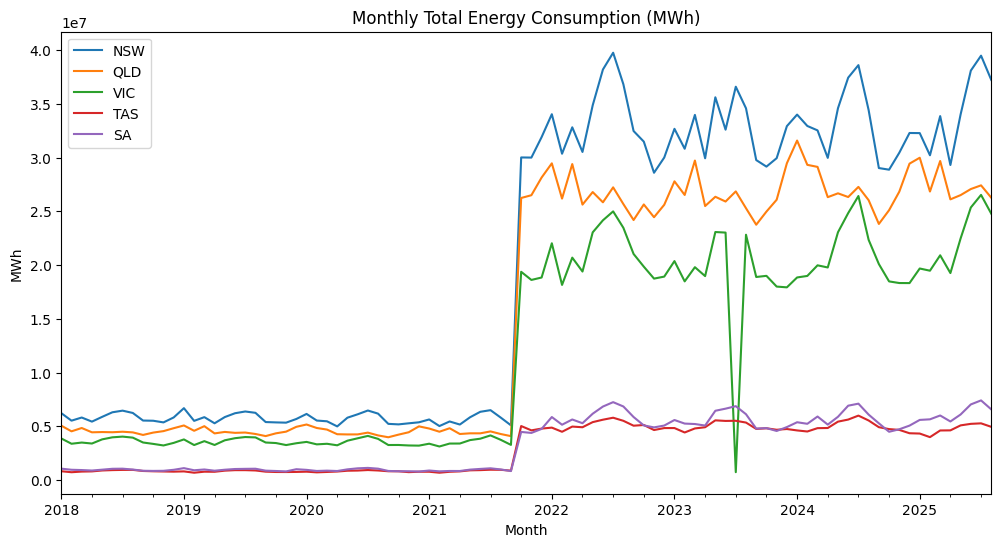

In [11]:
# Combine into one dataframe
df_monthly = pd.concat([NSW_m, QLD_m, VIC_m, TAS_m, SA_m], axis=1)

# Drop months with missing data
df_monthly = df_monthly.dropna()

# Remove incomplete last month (optional)
df_monthly = df_monthly.iloc[:-1]

# Plot
df_monthly.plot(figsize=(12,6))
plt.title("Monthly Total Energy Consumption (MWh)")
plt.xlabel("Month")
plt.ylabel("MWh")
plt.legend()
plt.show()


**Strong annual seasonality in all states**

- QLD & NSW track closely (high co-movement). VIC similar but with slightly larger winter amplitude in later years.

- SA & TAS are lower level but spikier (wind/solar + smaller system).

- A 2020–2022 dip then recovery appears across states (COVID + PV uptake effects).

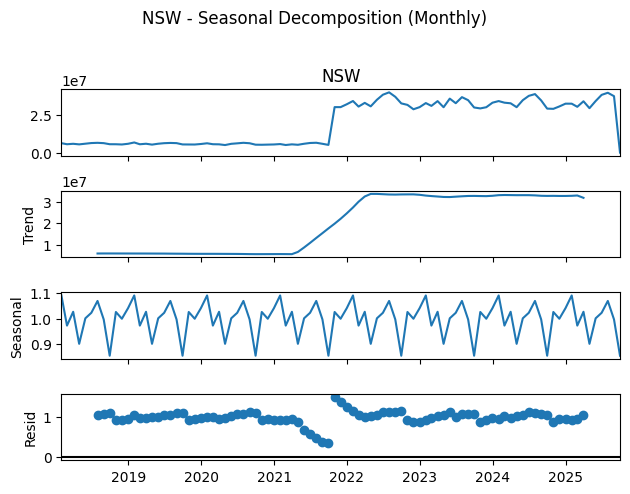

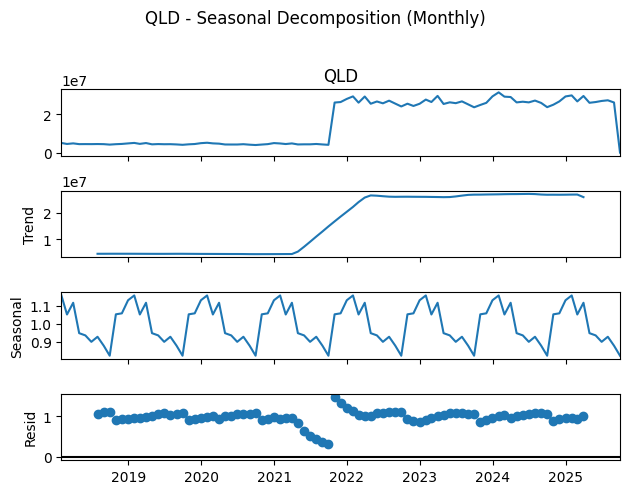

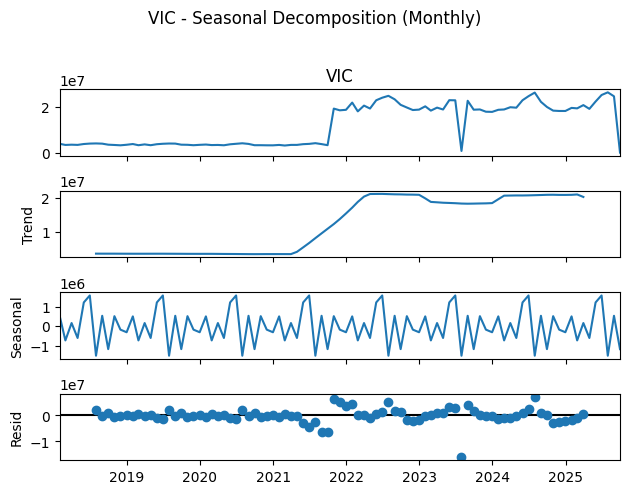

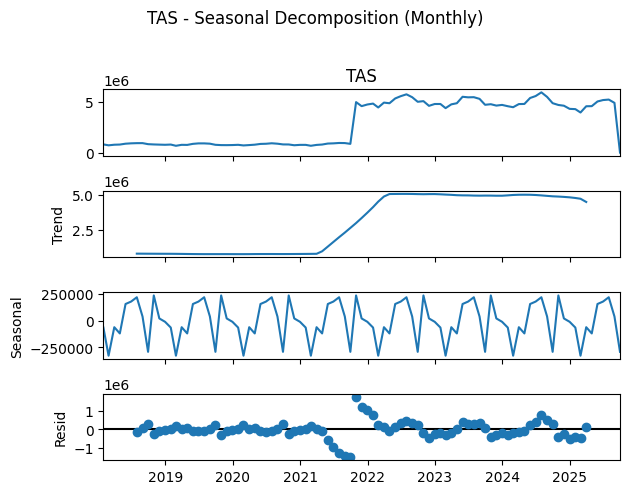

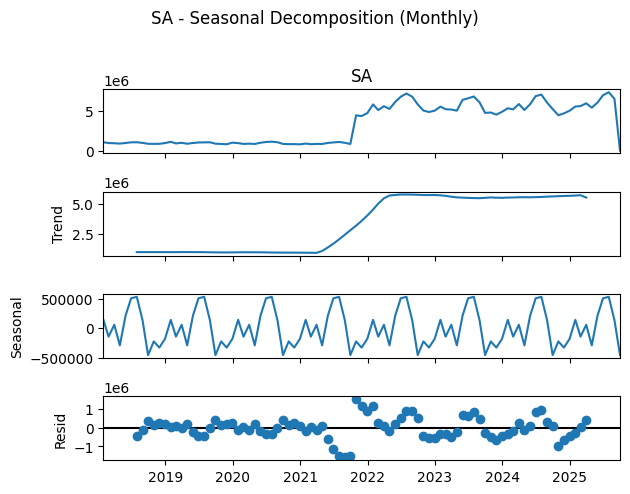

In [12]:
q_datalist = [("NSW", NSW_m), ("QLD", QLD_m), ("VIC", VIC_m), ("TAS", TAS_m), ("SA", SA_m)]

for name, df in q_datalist:
    y = df.sort_index().dropna()

    # NSW & QLD: multiplicative (ensure positivity), others: additive
    if name in {"NSW", "QLD"}:
        result = seasonal_decompose(y, model="multiplicative", period=12)
    else:
        result = seasonal_decompose(y, model="additive", period=12)

    # Use built-in plotting
    fig = result.plot()
    fig.suptitle(f"{name} - Seasonal Decomposition (Monthly)", y=1.02)
    plt.tight_layout()
    plt.show()


- Annual seasonality is strong across all states. Peaks in winter months; troughs in late spring/early summer are clear.

- **NSW & QLD benefit from multiplicative treatment**. Seasonal amplitude scales with level (winter peaks proportionally larger).

- COVID-era dip & recovery: Clear downtrend into ~2021–22 for NSW/VIC/SA, then rebound; QLD shows a sharper 2022–23 level shift.

- Residual autocorrelation remains. **Single-season classical decompose doesn’t remove weekly patterns or holiday/weather shocks**.

- TAS/SA: Lower absolute demand but relatively spikier residuals (small system + VRE variability).

# Time-series related EDA

In [13]:
train_cutoff = pd.to_datetime('2024-12-31')
target_end = pd.to_datetime('2025-09-02')  # 9 months

def split_by_index(s, train_start=None, train_cutoff=None, test_end=None):
    s = s.sort_index()
    if train_start is None:
        train_start = s.index.min()
    train = s.loc[(s.index >= train_start) & (s.index < train_cutoff)]
    test  = s.loc[(s.index >= train_cutoff) & (s.index <= test_end)]
    return train, test

NSW_train, NSW_test = split_by_index(NSW_m, train_cutoff=train_cutoff, test_end=target_end)
QLD_train, QLD_test = split_by_index(QLD_m, train_cutoff=train_cutoff, test_end=target_end)
VIC_train, VIC_test = split_by_index(VIC_m, train_cutoff=train_cutoff, test_end=target_end)
TAS_train, TAS_test = split_by_index(TAS_m, train_cutoff=train_cutoff, test_end=target_end)
SA_train, SA_test = split_by_index(SA_m, train_cutoff=train_cutoff, test_end=target_end)


print('NSW:', NSW_train.shape, NSW_test.shape)
print('QLD:', QLD_train.shape, QLD_test.shape)
print('VIC:', VIC_train.shape, VIC_test.shape)
print('TAS:', TAS_train.shape, TAS_test.shape)
print('SA:', SA_train.shape, SA_test.shape)

NSW: (83,) (9,)
QLD: (83,) (9,)
VIC: (83,) (9,)
TAS: (83,) (9,)
SA: (83,) (9,)


In [14]:
NSW_m.shape

(93,)

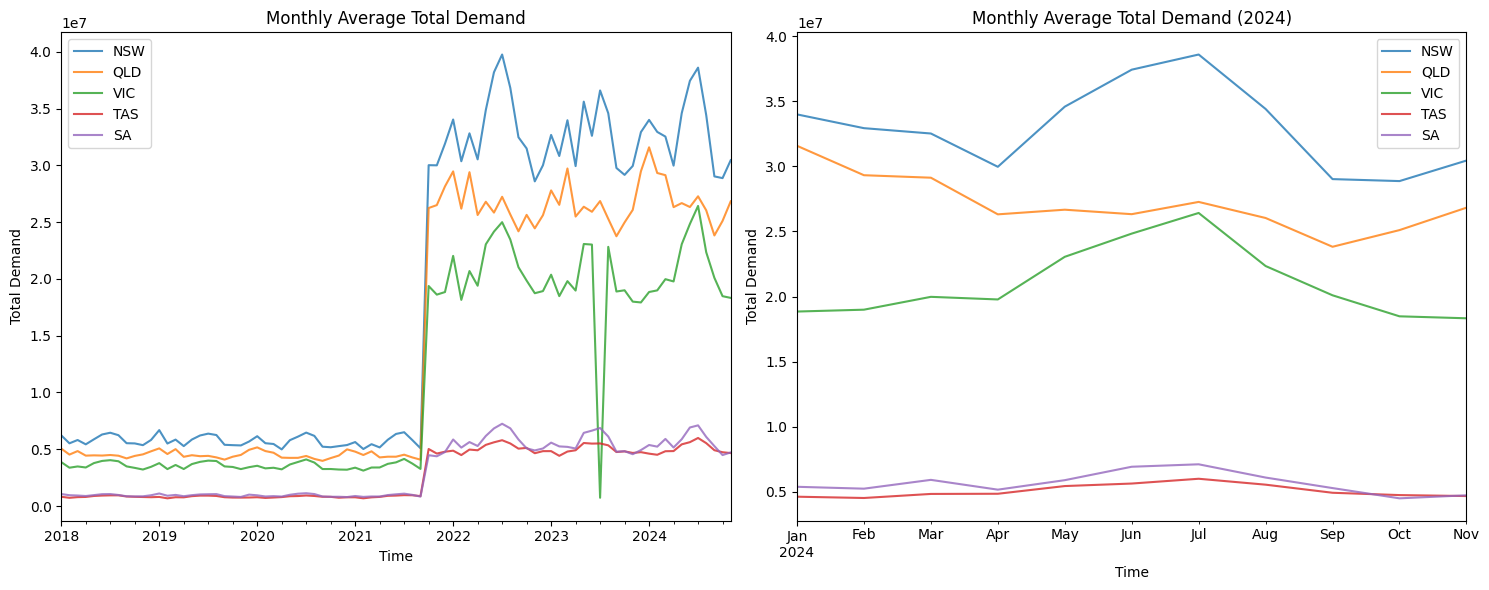

In [15]:
# plot the distribution of total demand over time for each state
train_list = {'NSW': NSW_train, 'QLD': QLD_train, 'VIC': VIC_train, 'TAS': TAS_train, 'SA': SA_train}
plt.figure(figsize=(15, 6))
plt.subplot(121)
for name, s in train_list.items():
    s.sort_index().plot(label=name, alpha=0.8)
plt.title("Monthly Average Total Demand")
plt.xlabel("Time"); plt.ylabel("Total Demand"); plt.legend()

plt.subplot(122)
start_date = '2024-01-01'
end_date   = '2024-12-31'

for name, s in train_list.items():
    s.sort_index().loc[start_date:end_date].plot(label=name, alpha=0.8)
plt.title("Monthly Average Total Demand (2024)")
plt.xlabel("Time"); plt.ylabel("Total Demand"); plt.legend()

plt.tight_layout()
plt.show()

- Clear winter peaks (Jun–Aug) across all states; NSW shows the largest seasonal swing, VIC second.

- QLD has a warmer-climate profile: smaller winter bump, flatter shoulders than NSW/VIC.

- SA/TAS lower level but spikier—small systems + VRE variability → bigger day-to-day swings.

- 2022 panel: NSW peaks ~Jun–Jul, VIC peak a touch later; QLD is flatter mid-year; SA/TAS ramp into winter then ease by Oct–Nov.

- Visual seasonality suggests **multiplicative effects for NSW/VIC** (amplitude scales with level). Consider logs or %-based seasonality for modeling.

## Stationary

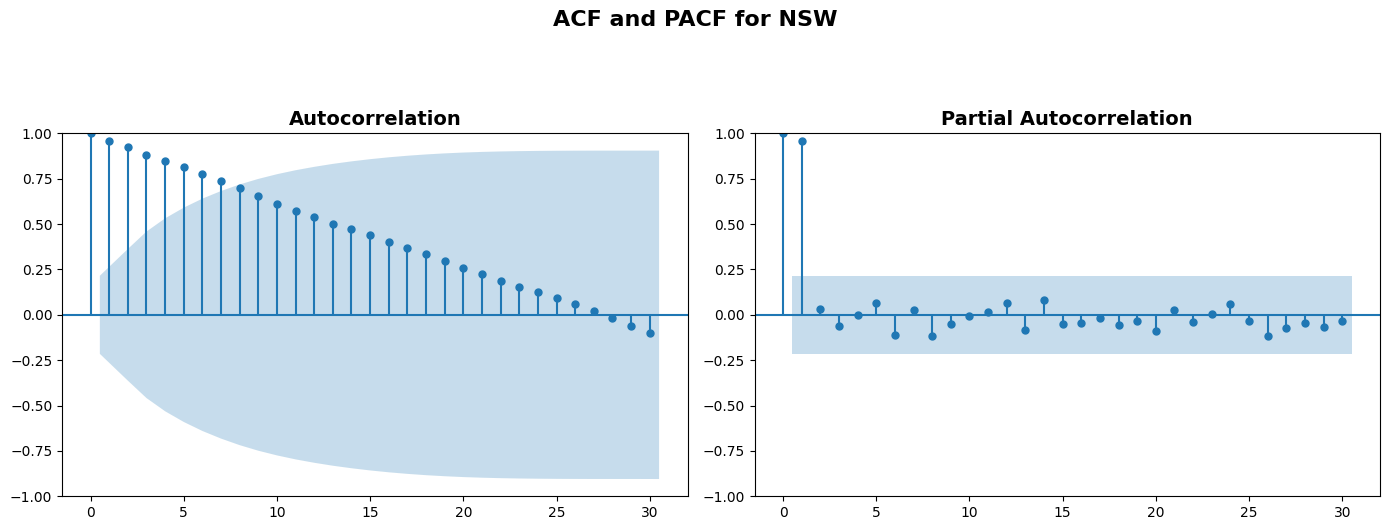

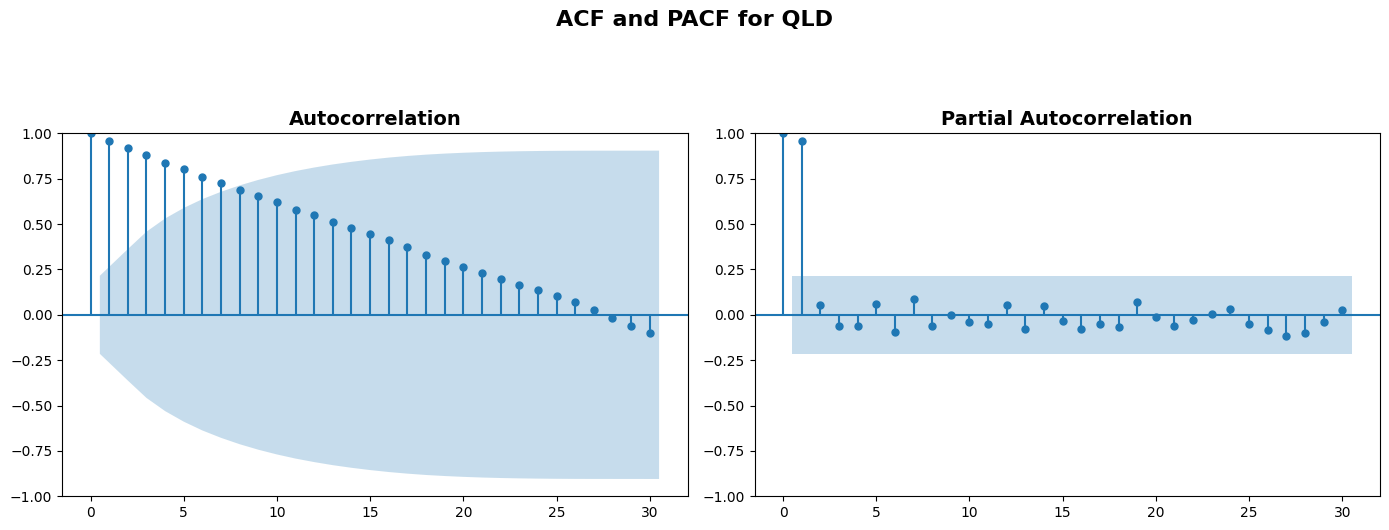

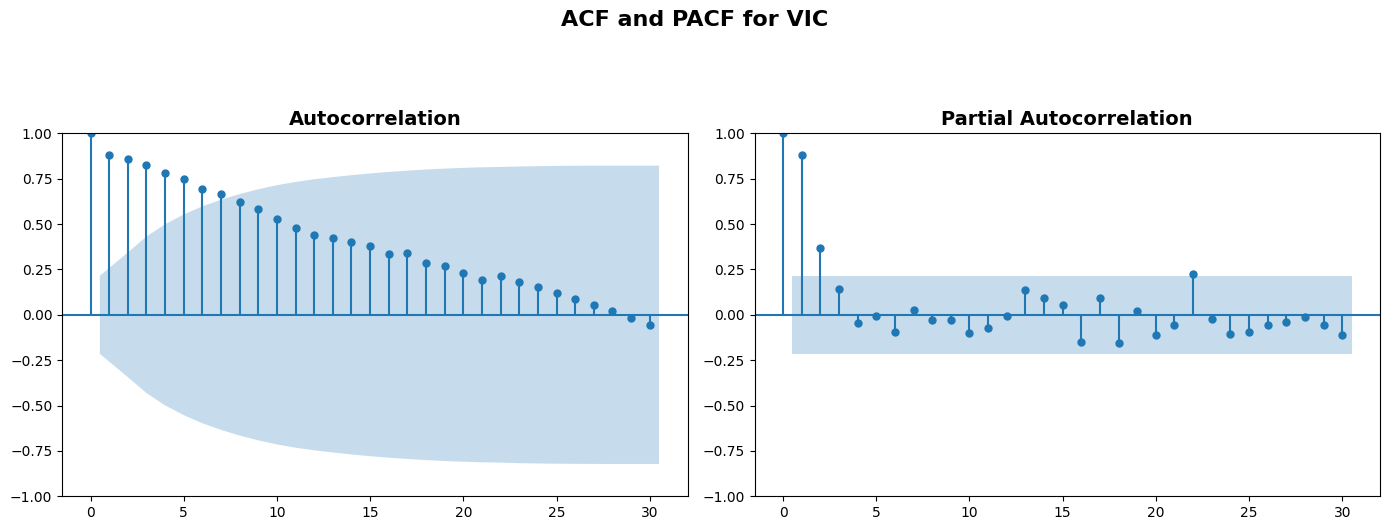

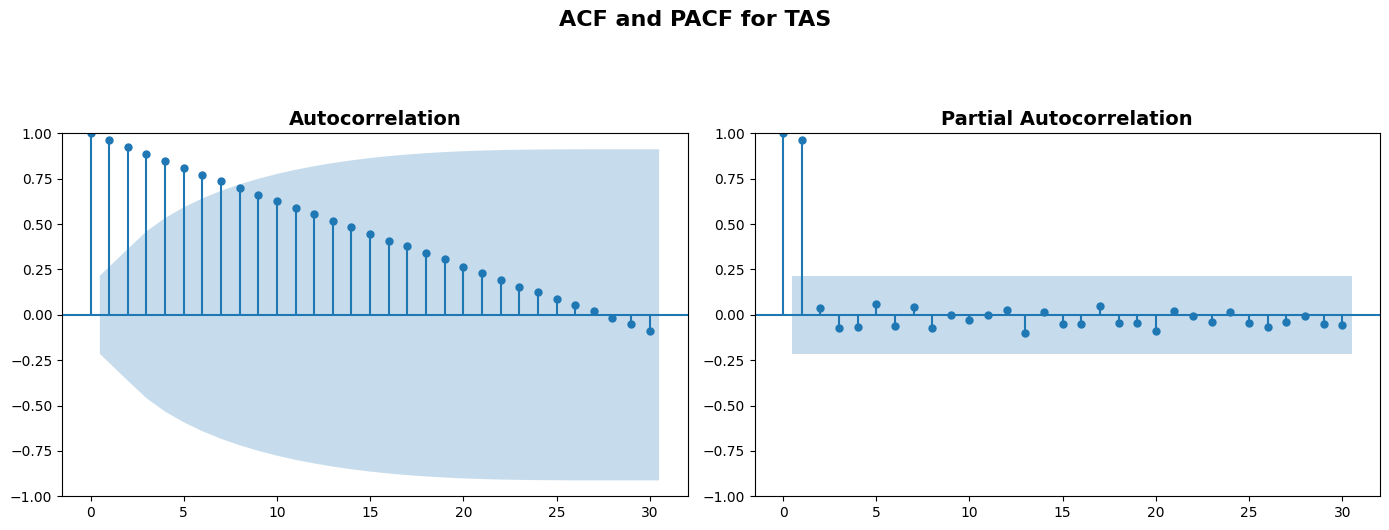

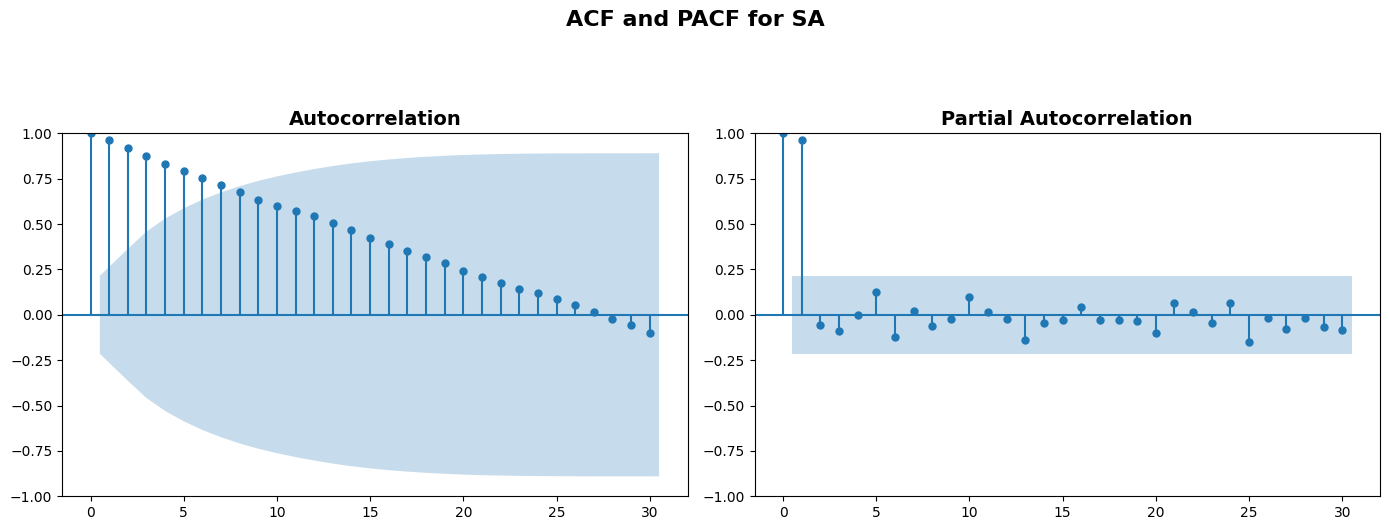

In [16]:
for name, series in train_list.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    
    sm.graphics.tsa.plot_acf(series, lags=30, alpha=0.05, ax=ax1)
    ax1.set_title("Autocorrelation", fontsize=14, fontweight="bold")
    
    sm.graphics.tsa.plot_pacf(series, lags=30, alpha=0.05, ax=ax2, method="ywm")
    ax2.set_title("Partial Autocorrelation", fontsize=14, fontweight="bold")
    
    fig.suptitle(f"ACF and PACF for {name}", fontsize=16, fontweight="bold", y=1.05)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

In [17]:
# adfuller test: statistical test used to determine if a time series is stationary or not by testing for the presence of a unit root. 
# The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root. 
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

adf_results = []

for name, series in train_list.items():
    test = adfuller(series.dropna())
    adf_results.append({
        'name': name,
        'statistic': test[0],   #ADF test statistic
        'pvalue': test[1],      # p-value that the series has a unit root (aka non-stationary)
        'n_lags': test[2],      # number of lags used in the test
        'n_obs': test[3],       # number of observations used in the test
        'crit_1%': test[4]['1%'],
        'crit_5%': test[4]['5%'],
        'crit_10%': test[4]['10%']
    })

df_adf = pd.DataFrame(adf_results)
print(df_adf)

  name  statistic    pvalue  n_lags  n_obs   crit_1%   crit_5%  crit_10%
0  NSW  -1.113067  0.709833       0     82 -3.512738 -2.897490 -2.585949
1  QLD  -1.020574  0.745686       0     82 -3.512738 -2.897490 -2.585949
2  VIC  -1.109290  0.711353       2     80 -3.514869 -2.898409 -2.586439
3  TAS  -1.081886  0.722241       0     82 -3.512738 -2.897490 -2.585949
4   SA  -1.175948  0.683856       0     82 -3.512738 -2.897490 -2.585949


### Differencing

In [18]:
m = 12 # monthly data, yearly seasonality
NSW_diff = NSW_train.diff(m).dropna()
QLD_diff = QLD_train.diff(m).dropna()
VIC_diff = VIC_train.diff(m).dropna()
TAS_diff = TAS_train.diff(m).dropna()
SA_diff = SA_train.diff(m).dropna()

# re-test stationarity after differencing
adf_results_diff = []
for name, series in zip(['NSW', 'QLD', 'VIC', 'TAS', 'SA'], [NSW_diff, QLD_diff, VIC_diff, TAS_diff, SA_diff]):
    test = adfuller(series.dropna())
    adf_results_diff.append({
        'name': name,
        'statistic': test[0],
        'pvalue': test[1],
        'n_lags': test[2],
        'n_obs': test[3],
        'crit_1%': test[4]['1%'],
        'crit_5%': test[4]['5%'],
        'crit_10%': test[4]['10%']
    })

df_adf_diff = pd.DataFrame(adf_results_diff)
print(df_adf_diff)

  name  statistic    pvalue  n_lags  n_obs   crit_1%   crit_5%  crit_10%
0  NSW  -1.829208  0.366060       0     70 -3.527426 -2.903811 -2.589320
1  QLD  -1.886951  0.338225       0     70 -3.527426 -2.903811 -2.589320
2  VIC  -1.929875  0.318140      12     58 -3.548494 -2.912837 -2.594129
3  TAS  -1.863845  0.349256       0     70 -3.527426 -2.903811 -2.589320
4   SA  -1.432716  0.566495      12     58 -3.548494 -2.912837 -2.594129


Seasonal differencing makes the data stationary -> m = 12

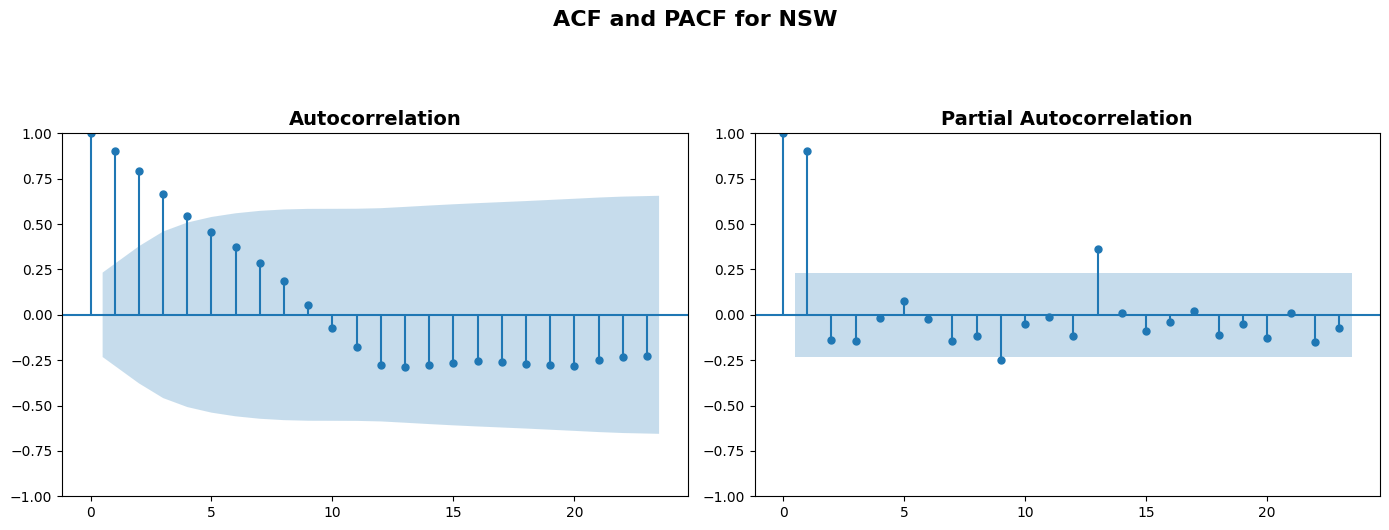

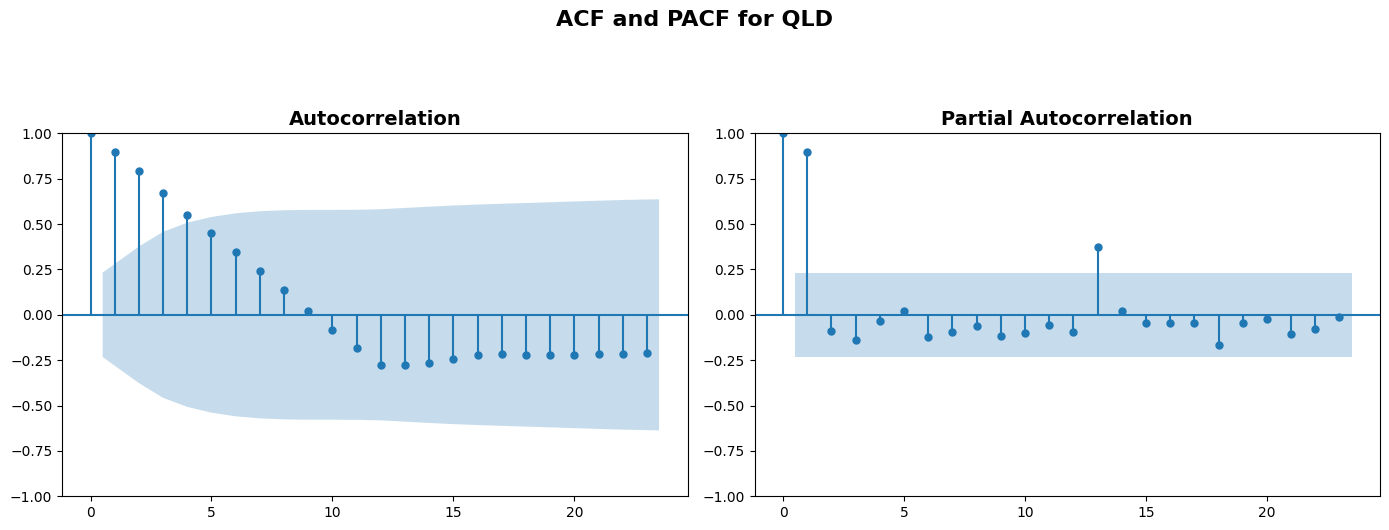

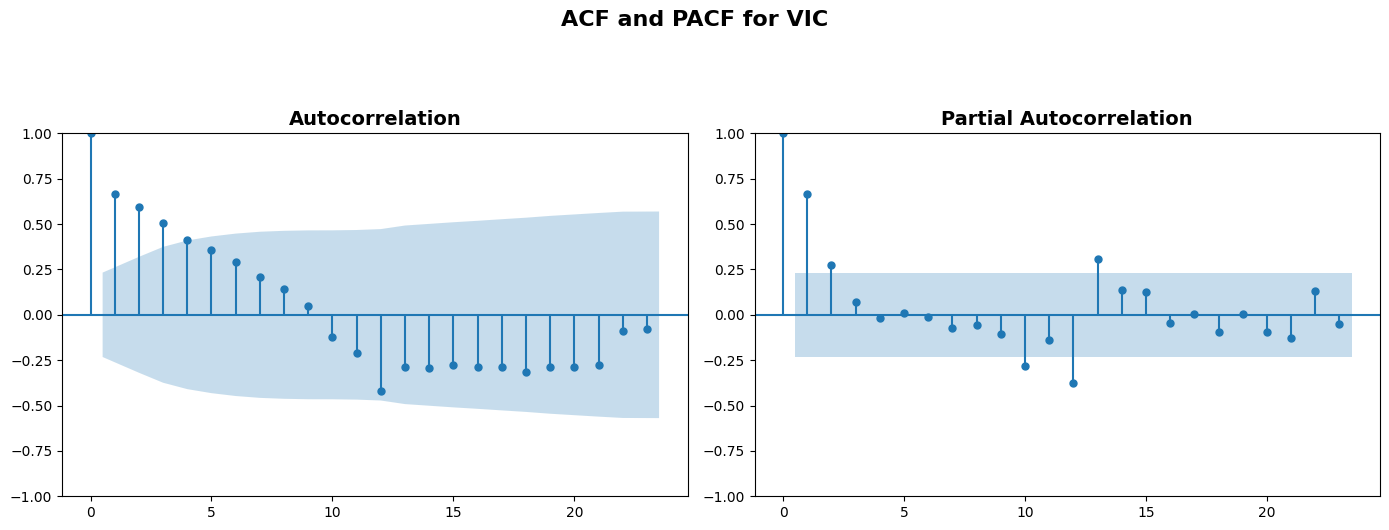

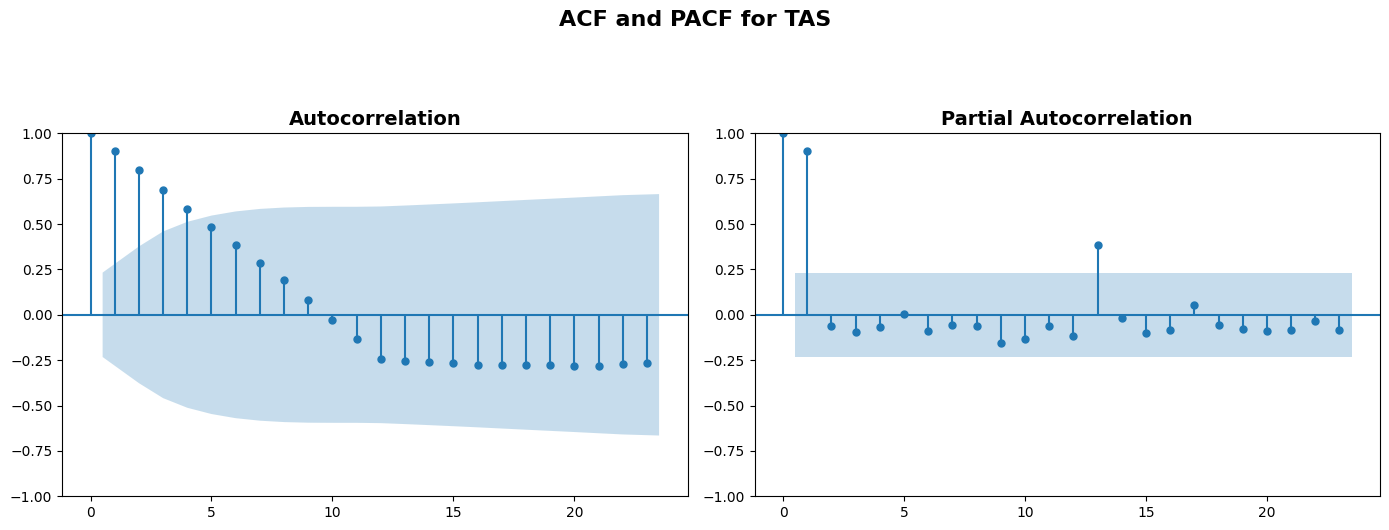

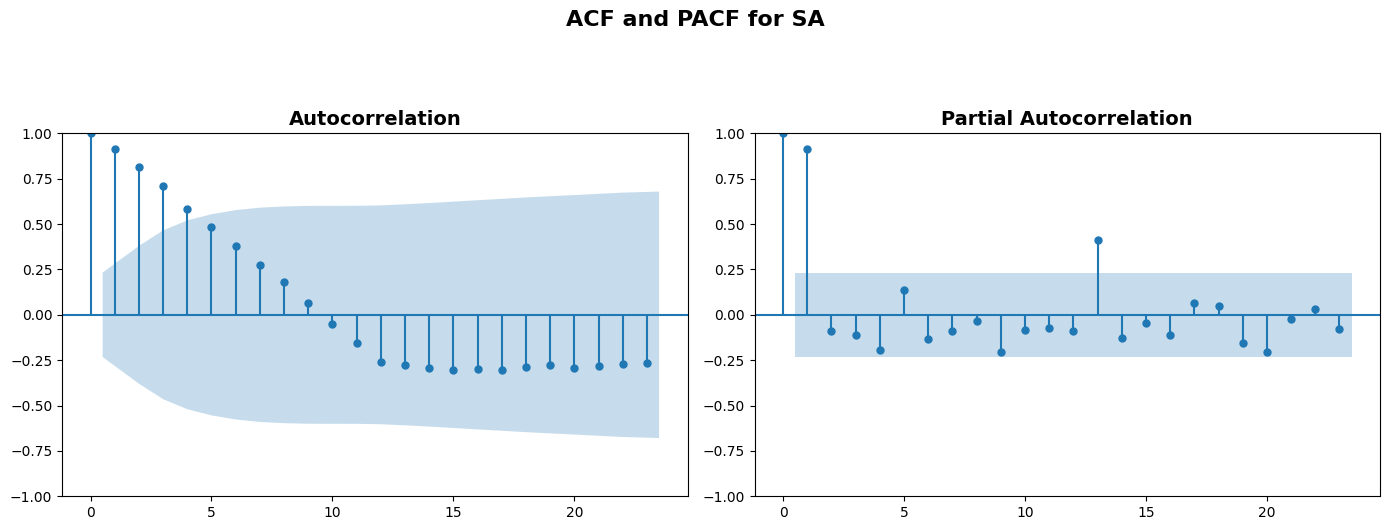

In [19]:
diff_list = {'NSW': NSW_diff, 'QLD': QLD_diff, 'VIC': VIC_diff, 'TAS': TAS_diff, 'SA': SA_diff}

for name, series in diff_list.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    
    # ACF
    sm.graphics.tsa.plot_acf(series, lags=23, alpha=0.05, ax=ax1)
    ax1.set_title("Autocorrelation", fontsize=14, fontweight="bold")
    
    # PACF
    sm.graphics.tsa.plot_pacf(series, lags=23, alpha=0.05, ax=ax2, method="ywm")
    ax2.set_title("Partial Autocorrelation", fontsize=14, fontweight="bold")
    
    fig.suptitle(f"ACF and PACF for {name}", fontsize=16, fontweight="bold", y=1.05)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# Time-series modelling
## Seasonal RW

In [20]:
season_length = 12 # monthly data with yearly seasonality
seasonal_rw_df = pd.DataFrame(index=NSW_test.index)

for name, series in train_list.items():
    history = series.dropna()
    forecast = []

    for h in range(1, len(NSW_test) + 1): 
        k = ((h - 1) // season_length) + 1
        index = -season_length * k

        if abs(index) >= len(history):
            yhat = history.iloc[-1] # fallback to last observation
        else: 
            yhat = history.iloc[index]

        forecast.append(yhat)

    seasonal_rw_df[name] = forecast

In [21]:
seasonal_rw_df

,NSW,QLD,VIC,TAS,SA
SETTLEMENTDATE,,,,,
2024-12-31,32923451.56,29471998.13,17924629.28,4742852.1,4924547.745
2025-01-31,32923451.56,29471998.13,17924629.28,4742852.1,4924547.745
2025-02-28,32923451.56,29471998.13,17924629.28,4742852.1,4924547.745
2025-03-31,32923451.56,29471998.13,17924629.28,4742852.1,4924547.745
2025-04-30,32923451.56,29471998.13,17924629.28,4742852.1,4924547.745
2025-05-31,32923451.56,29471998.13,17924629.28,4742852.1,4924547.745
2025-06-30,32923451.56,29471998.13,17924629.28,4742852.1,4924547.745
2025-07-31,32923451.56,29471998.13,17924629.28,4742852.1,4924547.745
2025-08-31,32923451.56,29471998.13,17924629.28,4742852.1,4924547.745


In [22]:
# Accurcy metrics
def mae(a, b): 
    return np.mean(np.abs(a - b))

def rmse(a, b): 
    return np.sqrt(np.mean((a - b) ** 2))

def mape(a, b): 
    return np.mean(np.abs((a - b) / a)) * 100

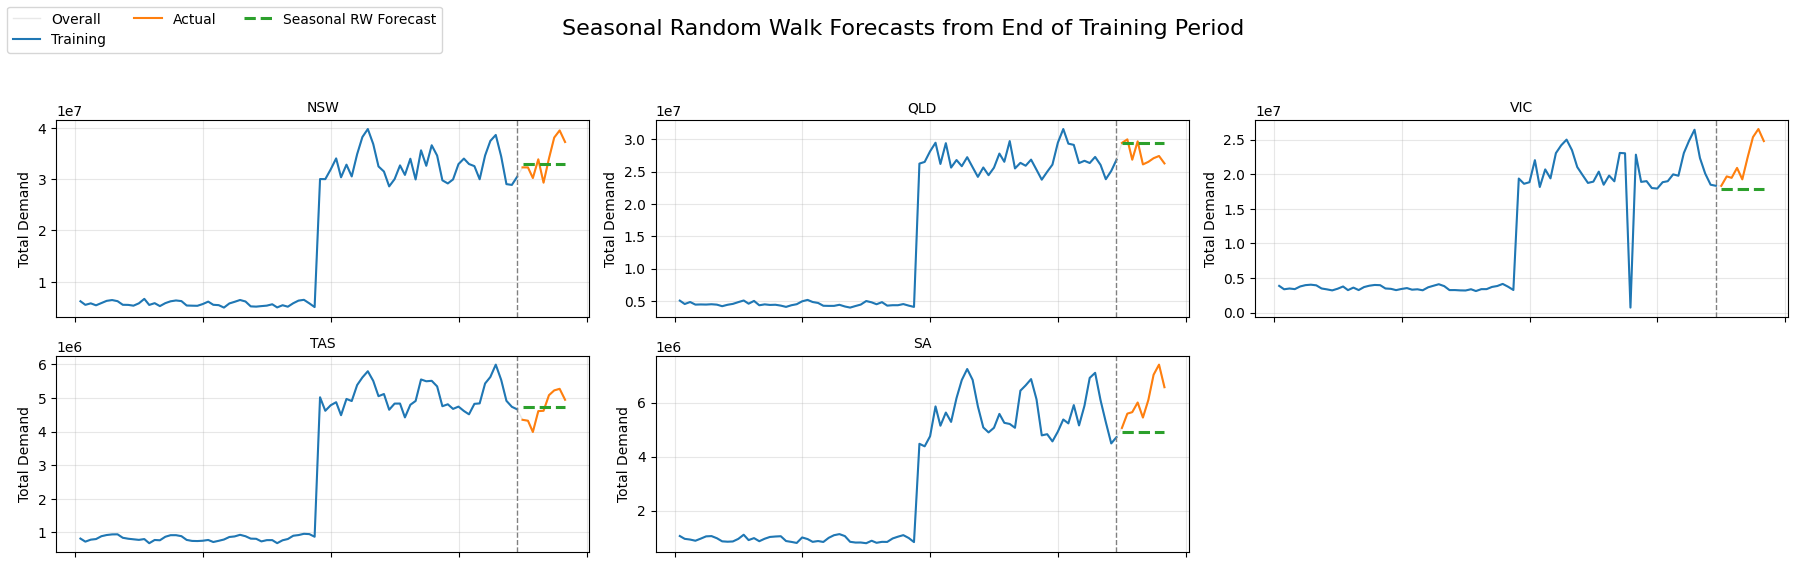

In [23]:
test_list =  {'NSW': NSW_test, 'QLD': QLD_test, 'VIC': VIC_test, 'TAS': TAS_test, 'SA': SA_test}
results = pd.DataFrame(columns=['Region', 'MAE', 'RMSE', 'MAPE'])

forecast_model_df_seasonal = seasonal_rw_df

names = list(train_list.keys())  # ['NSW','QLD','VIC']
n_cols = 3
n_rows = int(np.ceil(len(names) / n_cols))

fig, axes = plt.subplots(3, n_cols, figsize=(18, 4 * n_rows), sharex=True)
axes = np.atleast_1d(axes).ravel()

def idx_to_ts(s):
    idx = s.index
    return idx.to_timestamp() if hasattr(idx, 'to_timestamp') else idx

for i, name in enumerate(names):
    ax = axes[i]

    tr = train_list[name]                       # Series
    te = test_list[name]                        # Series
    fc = forecast_model_df_seasonal[name]       # Series or DataFrame column

    # X values (handle PeriodIndex or DatetimeIndex)
    x_tr = idx_to_ts(tr)
    x_te = idx_to_ts(te)
    x_fc = idx_to_ts(fc)
    
    # Ensure test and forecast data align for error metrics
    common_index = te.index.intersection(fc.index)
    te_aligned = te.loc[common_index]
    fc_aligned = fc.loc[common_index]
    
    # Calculate error metrics
    mae_value = mae(te_aligned.values, fc_aligned.values)
    rmse_value = rmse(te_aligned.values, fc_aligned.values)
    mape_value = mape(te_aligned.values, fc_aligned.values)
    
    # Append to results DataFrame
    results = pd.concat([results, pd.DataFrame({
        'Region': [name],
        'MAE': [mae_value],
        'RMSE': [rmse_value],
        'MAPE': [mape_value]
    })], ignore_index=True)
    
    combined = pd.concat([tr, te])
    ax.plot(combined.index, combined.values, color='lightgray', alpha=0.5, label='Overall', lw=1)

    ax.plot(x_tr, tr.values, label='Training', color='#1f77b4', lw=1.5)
    ax.plot(x_te, te.values, label='Actual',   color='#ff7f0e', lw=1.5)
    ax.plot(x_fc, fc.values, label='Seasonal RW Forecast',
            color='#2ca02c', lw=2.2, ls='--')

    # vertical split marker at end of training
    ax.axvline(x_tr[-1], color='gray', ls='--', lw=1)

    ax.set_title(name, fontsize=10)
    ax.set_ylabel('Total Demand')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Global legend and title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=3, fontsize=10)
fig.suptitle("Seasonal Random Walk Forecasts from End of Training Period", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [24]:
# Display results sorted by RMSE
results = results.sort_values('RMSE')
print("Forecasting Performance Metrics for Random Walk:")
print(results)

Forecasting Performance Metrics for Random Walk:
  Region           MAE          RMSE       MAPE
3    TAS  3.758377e+05  4.222595e+05   8.154234
4     SA  1.169835e+06  1.378215e+06  18.071777
1    QLD  1.930911e+06  2.299665e+06   7.219326
0    NSW  2.852249e+06  3.520423e+06   8.112096
2    VIC  3.938781e+06  4.866978e+06  16.649488


## SES

In [25]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses_models, fc_ses_dict = {}, {}
rows_ses = []

for name in train_list.keys():
    tr = train_list[name].astype(float).copy()
    te = test_list[name].astype(float).copy()
    h  = len(te)

    ses = SimpleExpSmoothing(tr, initialization_method="estimated").fit(optimized=True)
    ses_models[name] = ses

    fc_ses = ses.forecast(h)
    fc_ses.index = te.index
    fc_ses_dict[name] = fc_ses

    rows_ses.append({
        "region": name,
        "model": "SES (level-only)",
        "AIC": ses.aic,
        "MAE": mae(te, fc_ses),
        "RMSE": rmse(te, fc_ses),
        "MAPE": mape(te, fc_ses)
    })

result_ses = pd.DataFrame(rows_ses)
result_ses


,region,model,AIC,MAE,RMSE,MAPE
0,NSW,SES (level-only),2500.008332,3.985366e+06,4.984218e+06,10.975892
1,QLD,SES (level-only),2465.568119,1.272968e+06,1.779099e+06,4.385784
2,VIC,SES (level-only),2510.311175,2.829860e+06,3.882171e+06,11.657381
3,TAS,SES (level-only),2183.660155,3.676113e+05,4.234135e+05,7.853492
4,SA,SES (level-only),2210.909817,1.375478e+06,1.556568e+06,21.493002


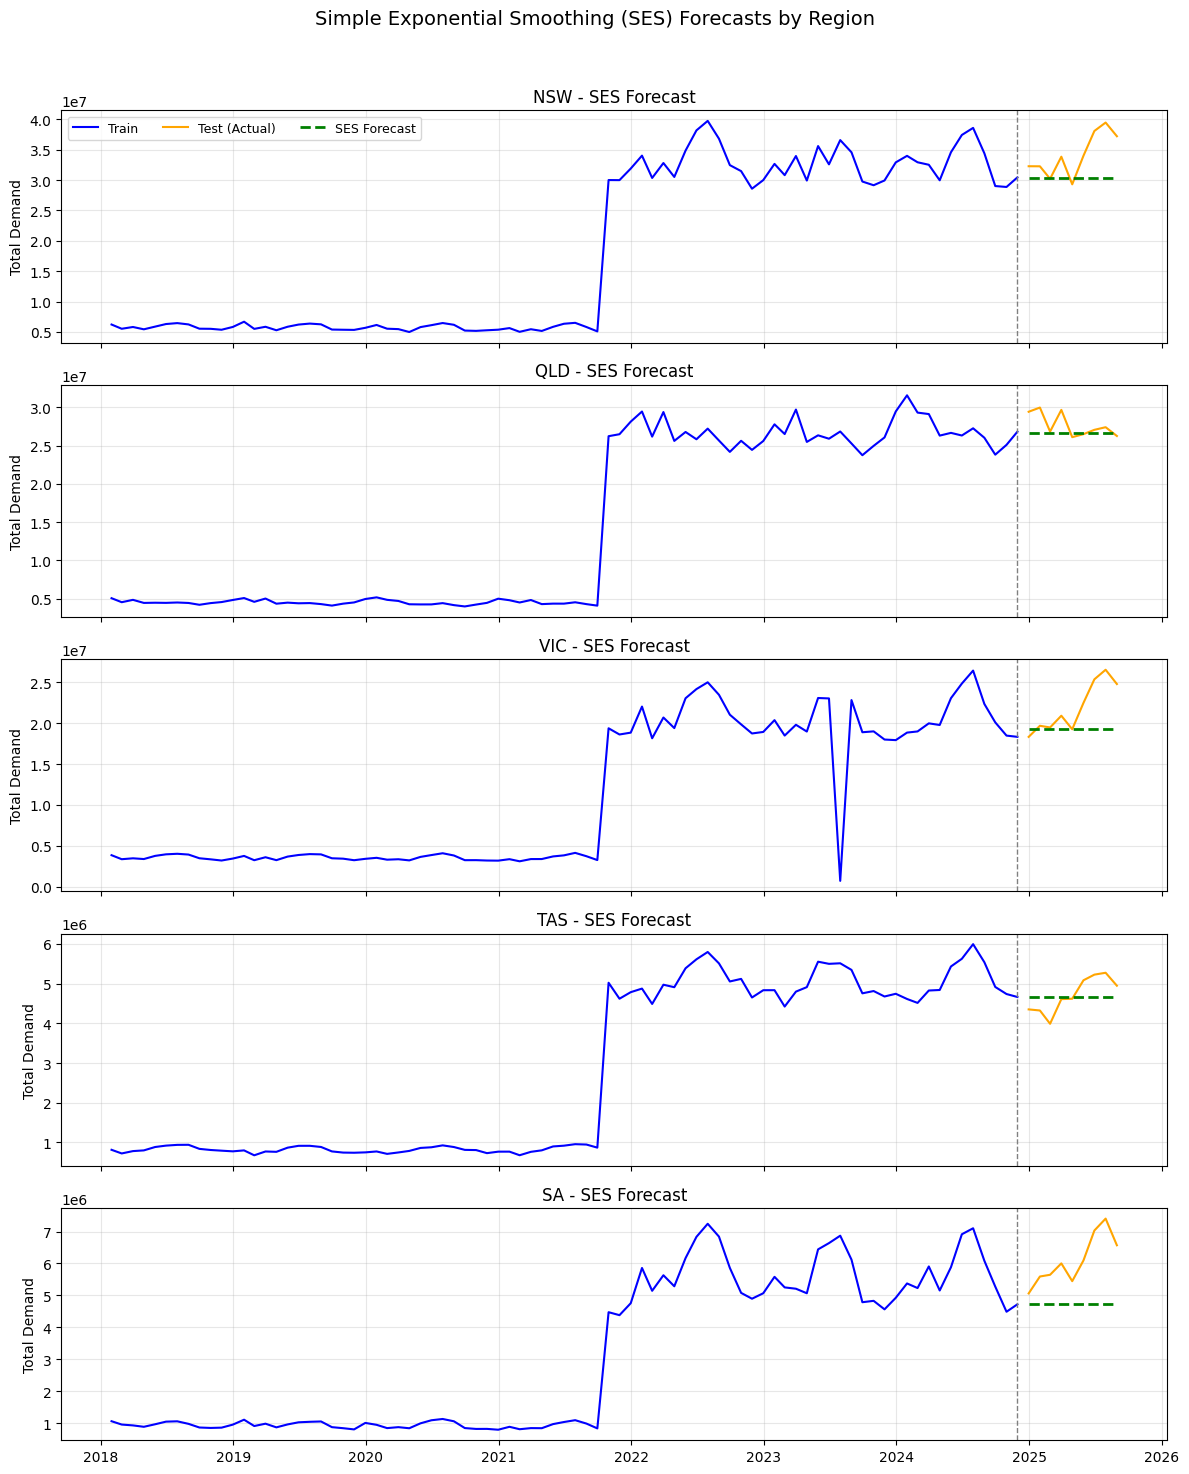

In [26]:
fig, axes = plt.subplots(len(train_list), 1, figsize=(12, 3*len(train_list)), sharex=True)

if len(train_list) == 1:
    axes = [axes]  # ensure iterable if only one region

for i, name in enumerate(train_list.keys()):
    ax = axes[i]

    tr = train_list[name]
    te = test_list[name]
    fc = fc_ses_dict[name]

    # Plot training, test, and forecast
    ax.plot(tr.index, tr.values, label="Train", color="blue", lw=1.5)
    ax.plot(te.index, te.values, label="Test (Actual)", color="orange", lw=1.5)
    ax.plot(fc.index, fc.values, label="SES Forecast", color="green", lw=2, ls="--")

    # Mark cutoff
    ax.axvline(tr.index[-1], color="gray", ls="--", lw=1)

    ax.set_title(f"{name} - SES Forecast", fontsize=12)
    ax.set_ylabel("Total Demand")
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

axes[0].legend(loc="upper left", ncol=3, fontsize=9)
plt.suptitle("Simple Exponential Smoothing (SES) Forecasts by Region", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Holt winter

In [27]:
hw_models, fc_hw_dict = {}, {}
rows_hw = []

for name in train_list.keys():
    tr = train_list[name].astype(float).copy()
    te = test_list[name].astype(float).copy()
    h  = len(te)
    sp = 12

    # choose seasonal type by region
    seasonal_type = "mul" if name in ["NSW", "QLD"] else "add"

    # --- Fit HW (level + seasonal, no trend) ---
    hw = ExponentialSmoothing(
        tr, seasonal=seasonal_type, seasonal_periods=sp,
        initialization_method="estimated"
    ).fit(optimized=True)
    hw_models[name] = hw

    # --- Forecast ---
    fc_hw = hw.forecast(h)
    fc_hw.index = te.index
    fc_hw_dict[name] = fc_hw

    # --- Metrics ---
    rows_hw.append({
        "region": name,
        "model": "HW seasonal",
        "AIC": hw.aic,
        "MAE": mae(te, fc_hw),
        "RMSE": rmse(te, fc_hw),
        "MAPE": mape(te, fc_hw)
    })

result_hw = pd.DataFrame(rows_hw)
result_hw


,region,model,AIC,MAE,RMSE,MAPE
0,NSW,HW seasonal,2539.783030,5.705465e+06,6.918148e+06,15.952617
1,QLD,HW seasonal,4304.603325,8.991289e+08,1.447064e+09,3249.231574
2,VIC,HW seasonal,2533.788776,3.633713e+06,4.692751e+06,15.228781
3,TAS,HW seasonal,2198.563363,5.325931e+05,6.134007e+05,10.886927
4,SA,HW seasonal,2226.948486,1.487355e+06,1.691477e+06,23.243128


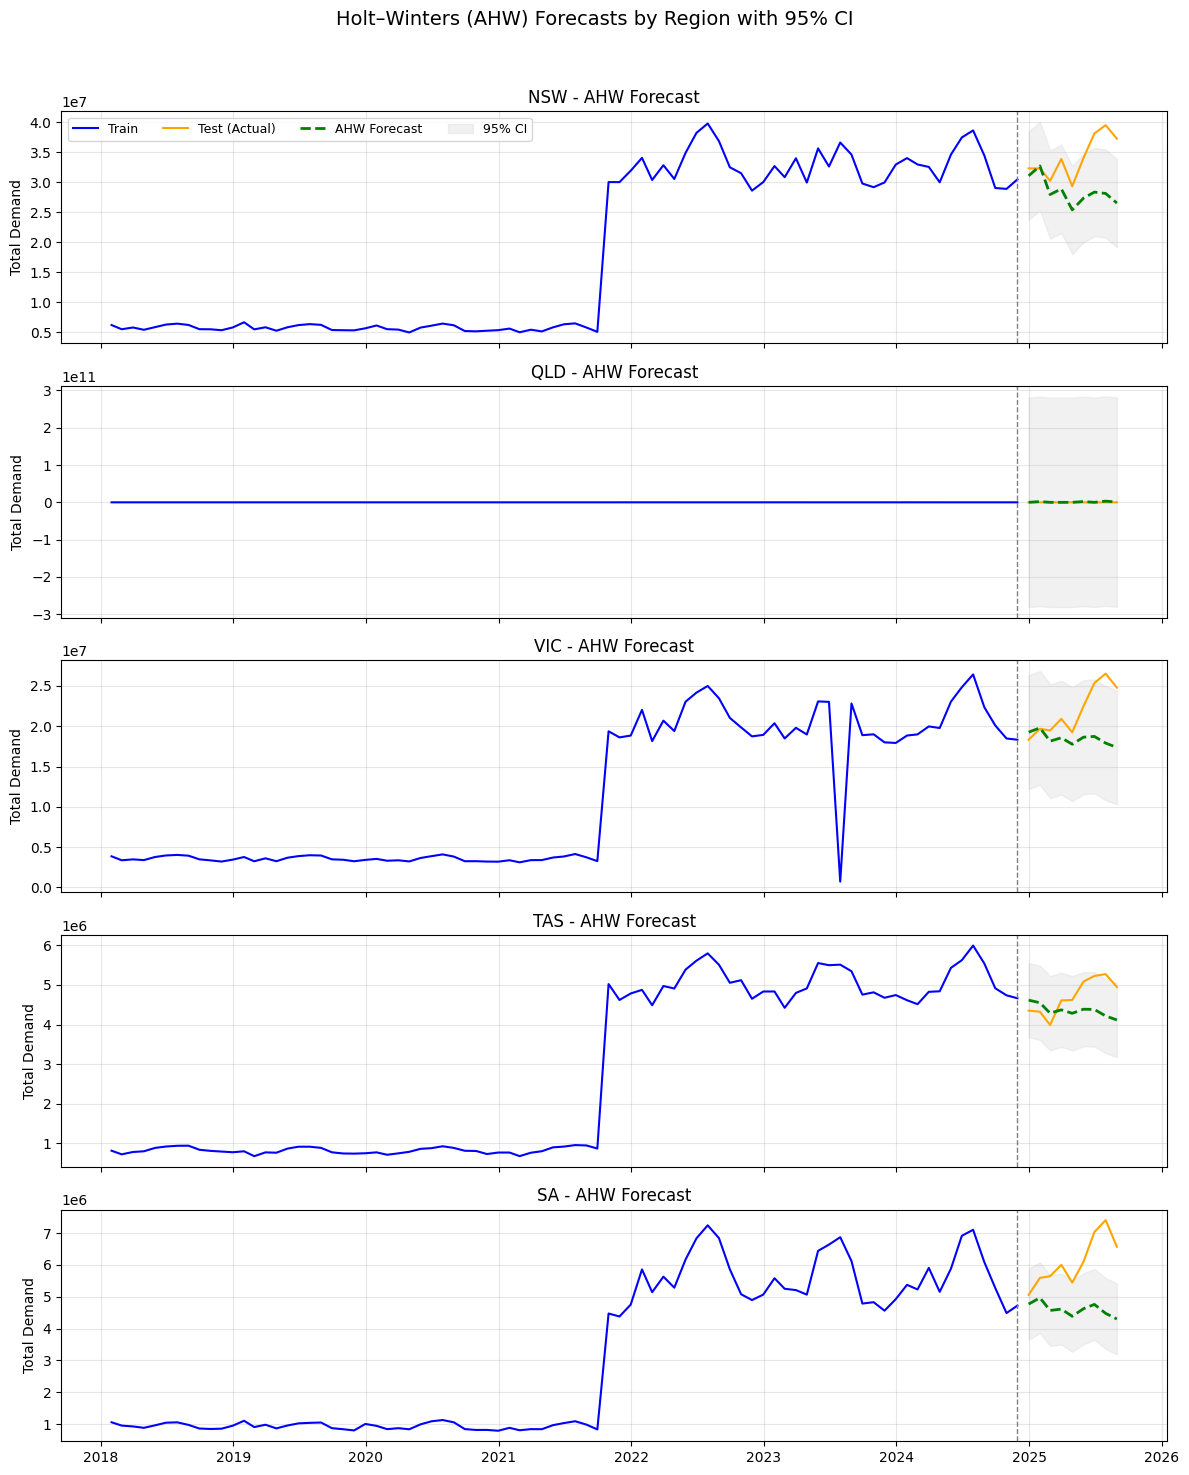

In [28]:
fig, axes = plt.subplots(len(train_list), 1, figsize=(12, 3*len(train_list)), sharex=True)

if len(train_list) == 1:
    axes = [axes]

for i, name in enumerate(train_list.keys()):
    ax = axes[i]

    tr = train_list[name]
    te = test_list[name]
    fc = fc_hw_dict[name]          
    model = hw_models[name]         

    # Residual std for CI
    sigma = np.std(model.resid, ddof=1)
    fc_lower, fc_upper = fc - 1.96*sigma, fc + 1.96*sigma

    # Plot train, test, forecast + CI
    ax.plot(tr.index, tr.values, label="Train", color="blue", lw=1.5)
    ax.plot(te.index, te.values, label="Test (Actual)", color="orange", lw=1.5)
    ax.plot(fc.index, fc.values, label="AHW Forecast", color="green", lw=2, ls="--")
    ax.fill_between(fc.index, fc_lower, fc_upper, color="lightgray", alpha=0.3, label="95% CI")

    # Mark cutoff
    ax.axvline(tr.index[-1], color="gray", ls="--", lw=1)

    ax.set_title(f"{name} - AHW Forecast", fontsize=12)
    ax.set_ylabel("Total Demand")
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

axes[0].legend(loc="upper left", ncol=4, fontsize=9)
plt.suptitle("Holt–Winters (AHW) Forecasts by Region with 95% CI", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## AHW with damped trend

In [29]:
hwd_models, fc_hwd_dict = {}, {}
rows_hwd = []

for name in train_list.keys():
    tr = train_list[name].astype(float).copy()
    te = test_list[name].astype(float).copy()
    h  = len(te)
    sp = 12

    # choose seasonal type by region
    seasonal_type = "mul" if name in ["NSW", "QLD"] else "add"

    hwd = ExponentialSmoothing(
        tr, trend='add', damped_trend=True,
        seasonal=seasonal_type, seasonal_periods=sp,
        initialization_method="estimated"
    ).fit(optimized=True)
    hwd_models[name] = hwd

    fc_hwd = hwd.forecast(h)
    fc_hwd.index = te.index
    fc_hwd_dict[name] = fc_hwd

    rows_hwd.append({
        "region": name,
        "AIC": hwd.aic,
        "MAE": mae(te, fc_hwd),
        "RMSE": rmse(te, fc_hwd),
        "MAPE": mape(te, fc_hwd)
    })

result_hw = pd.DataFrame(rows_hwd)
result_hw


,region,AIC,MAE,RMSE,MAPE
0,NSW,2545.808799,5.668206e+06,6.879033e+06,15.843904
1,QLD,2514.167868,4.093487e+06,4.673389e+06,15.059669
2,VIC,2538.119941,2.412385e+06,3.269088e+06,10.051773
3,TAS,2204.616691,5.354746e+05,6.172562e+05,10.942444
4,SA,2232.945747,1.485529e+06,1.689465e+06,23.214285


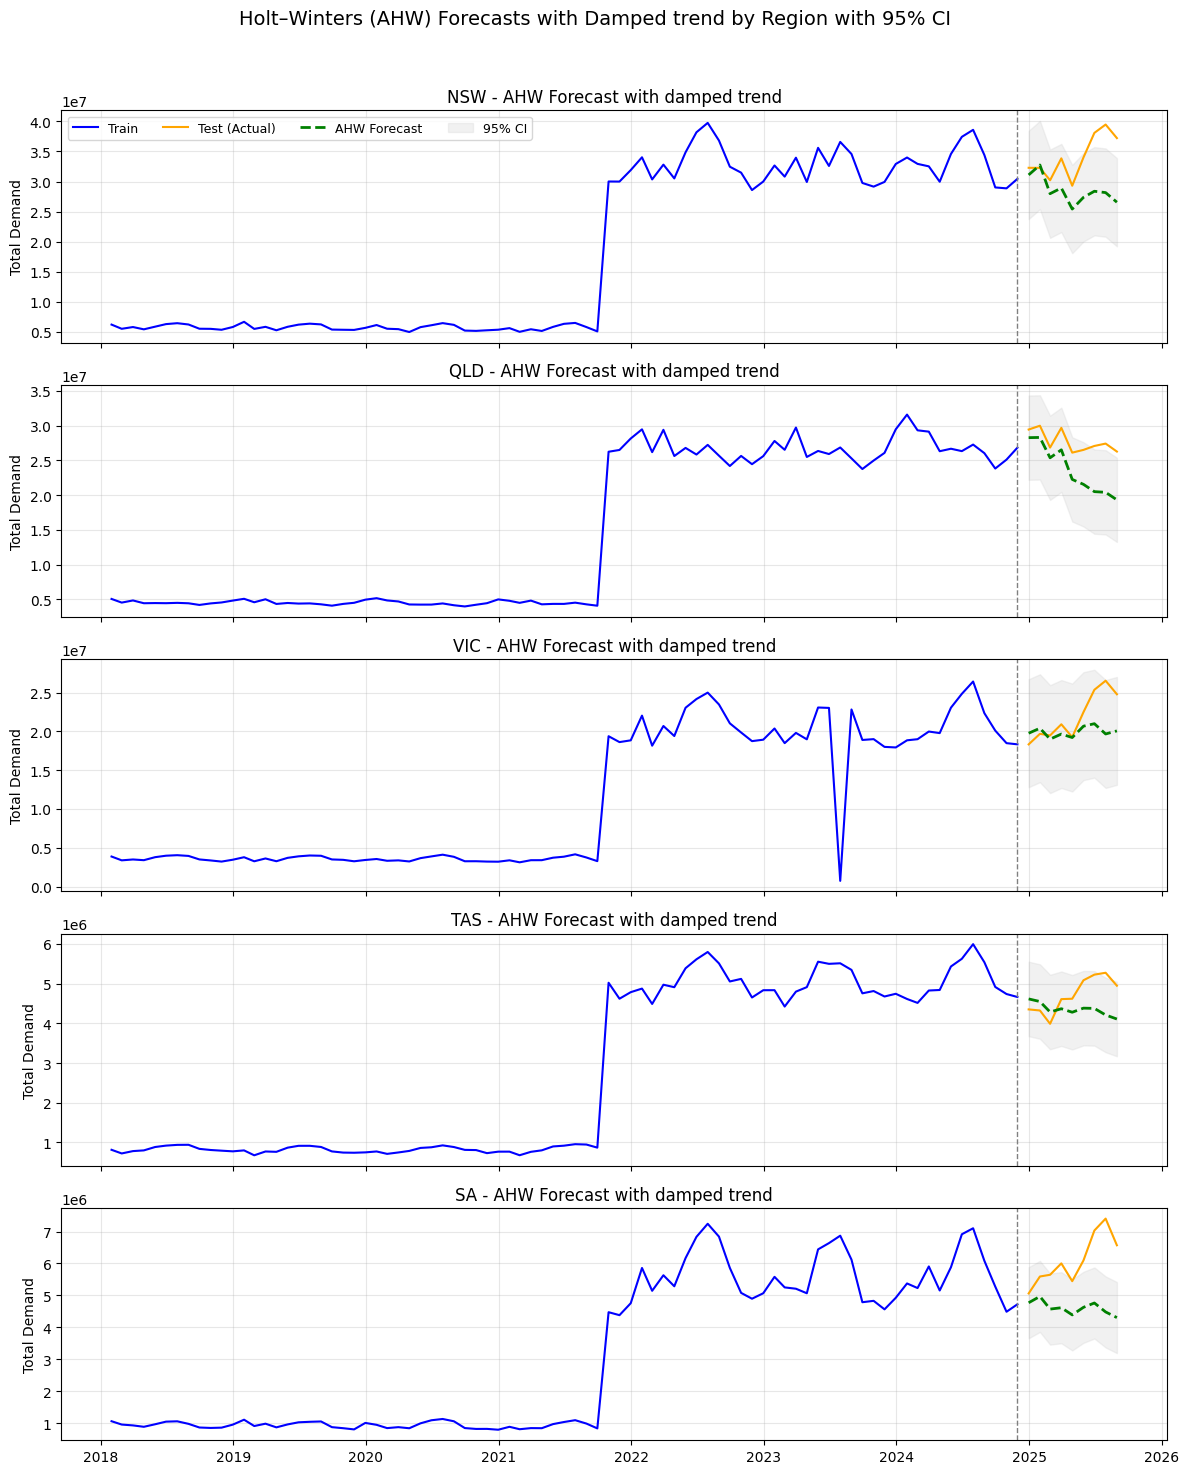

In [30]:
fig, axes = plt.subplots(len(train_list), 1, figsize=(12, 3*len(train_list)), sharex=True)

if len(train_list) == 1:
    axes = [axes]

for i, name in enumerate(train_list.keys()):
    ax = axes[i]

    tr = train_list[name]
    te = test_list[name]
    fc = fc_hwd_dict[name]       
    model = hwd_models[name]   

    # Residual std for CI
    sigma = np.std(model.resid, ddof=1)
    fc_lower, fc_upper = fc - 1.96*sigma, fc + 1.96*sigma

    # Plot train, test, forecast + CI
    ax.plot(tr.index, tr.values, label="Train", color="blue", lw=1.5)
    ax.plot(te.index, te.values, label="Test (Actual)", color="orange", lw=1.5)
    ax.plot(fc.index, fc.values, label="AHW Forecast", color="green", lw=2, ls="--")
    ax.fill_between(fc.index, fc_lower, fc_upper, color="lightgray", alpha=0.3, label="95% CI")

    # Mark cutoff
    ax.axvline(tr.index[-1], color="gray", ls="--", lw=1)

    ax.set_title(f"{name} - AHW Forecast with damped trend", fontsize=12)
    ax.set_ylabel("Total Demand")
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Add one legend
axes[0].legend(loc="upper left", ncol=4, fontsize=9)
plt.suptitle("Holt–Winters (AHW) Forecasts with Damped trend by Region with 95% CI", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## ARIMA

In [31]:
def evaluate_sarima(y_train, y_test, candidates, horizon=None, region_name="Region", use_log=False, bias_correction=True):
    """
    Fit and compare multiple SARIMA candidate models on a given time series.

    Parameters
    ----------
    y_train : pd.Series
        Training time series (datetime index).
    y_test : pd.Series
        Test time series (datetime index).
    candidates : list of tuples
        Each tuple = (p,d,q,P,D,Q,s).
    horizon : int, optional
        Forecast horizon. If None, uses len(y_test).
    region_name : str
        Name of the region/dataset (for printing/debugging).
    use_log : bool, default=False
        If True, log-transform the series before fitting.
    bias_correction : bool, default=True
        If True and use_log=True, apply exp(μ + 0.5σ²) correction
        when back-transforming forecasts.

    Returns
    -------
    results_df : pd.DataFrame
        Comparison table of models [Model, AIC, MAE, RMSE].
    fits : dict
        Dictionary of fitted models, keyed by model string.
    """
    h = horizon or len(y_test)
    rows, fits = [], {}

    # transform if requested
    y_tr = np.log(y_train) if use_log else y_train
    y_te = y_test.copy()   # keep original scale for metrics

    for p,d,q,P,D,Q,s in candidates:
        try:
            res = sm.tsa.SARIMAX(
                y_tr, order=(p,d,q),
                seasonal_order=(P,D,Q,s),
                enforce_stationarity=True,
                enforce_invertibility=True
            ).fit(disp=False)

            fc_res = res.get_forecast(h)
            fc_mean = fc_res.predicted_mean

            if use_log:
                # variance of prediction distribution
                var = fc_res.var_pred_mean
                if bias_correction:
                    fc = np.exp(fc_mean + 0.5 * var)  # log-normal correction
                else:
                    fc = np.exp(fc_mean)
            else:
                fc = fc_mean

            fc.index = y_test.index  # align with test

            mae = np.mean(np.abs(y_te - fc))
            rmse = np.sqrt(np.mean((y_te - fc)**2))

            model_str = f"({p},{d},{q})x({P},{D},{Q},{s})"
            if use_log:
                model_str = "log-" + model_str

            rows.append([model_str, res.aic, mae, rmse])
            fits[model_str] = res

        except Exception as e:
            print(f"⚠️ Failed to fit {region_name} model {p,d,q,P,D,Q,s}: {e}")

    results_df = pd.DataFrame(rows, columns=["Model", "AIC", "MAE", "RMSE"]).sort_values("AIC")
    return results_df, fits


Based on the previous EDA, we have the candidates for each of the regional dataset

In [32]:
# FOR NSW
cands = [
    ((1,0,0, 0,1,1,12)),
    ((1,0,1, 0,1,1,12)),
    ((2,0,0, 0,1,1,12)),
    ((1,0,0, 1,1,1,12)),
    ((1,0,1, 1,1,1,12)),
]

cmp, fits = evaluate_sarima(NSW_train, NSW_test, cands, region_name="NSW", use_log=True)
print(cmp)

# get best model
best_model_str = cmp.iloc[0]["Model"]
best_model = fits[best_model_str]


                    Model       AIC           MAE          RMSE
0  log-(1,0,0)x(0,1,1,12)  3.422874  1.391669e+06  1.713752e+06
3  log-(1,0,0)x(1,1,1,12)  5.266759  1.442510e+06  1.777682e+06
2  log-(2,0,0)x(0,1,1,12)  5.423104  1.542509e+06  1.912023e+06
1  log-(1,0,1)x(0,1,1,12)  5.423390  1.602567e+06  1.997403e+06
4  log-(1,0,1)x(1,1,1,12)  7.273347  1.642183e+06  2.058127e+06


In [33]:
# FOR QLD
cands = [
    ((1,0,1, 0,1,1,12)),
    ((0,0,1, 0,1,1,12)),
    ((2,0,1, 0,1,1,12)),
    ((1,0,1, 1,1,1,12)),
    ((1,0,0, 0,1,1,12)),
]

cmp, fits = evaluate_sarima(QLD_train, QLD_test, cands, region_name="QLD", use_log=True)
print(cmp)

# get best model
best_model_str = cmp.iloc[0]["Model"]
best_model = fits[best_model_str]


                    Model         AIC           MAE          RMSE
4  log-(1,0,0)x(0,1,1,12)    3.800612  5.937915e+05  7.053742e+05
0  log-(1,0,1)x(0,1,1,12)    5.795179  6.054076e+05  7.174502e+05
2  log-(2,0,1)x(0,1,1,12)    7.493335  3.792550e+05  5.729239e+05
3  log-(1,0,1)x(1,1,1,12)    7.710200  6.572361e+05  7.804357e+05
1  log-(0,0,1)x(0,1,1,12)  101.378239  5.401002e+06  5.550619e+06


In [34]:
# FOR VIC
cands = [
    ((1,0,1, 0,1,1,12)),
    ((1,0,0, 0,1,1,12)),
    ((0,0,1, 0,1,1,12)),
    ((1,0,1, 1,1,1,12)),
]

cmp, fits = evaluate_sarima(VIC_train, VIC_test, cands, region_name="VIC", use_log=False)
print(cmp)

# get best model
best_model_str = cmp.iloc[0]["Model"]
best_model = fits[best_model_str]


                Model          AIC           MAE          RMSE
3  (1,0,1)x(1,1,1,12)  2389.417538  2.776532e+06  5.294774e+06
0  (1,0,1)x(0,1,1,12)  2391.405792  2.291682e+06  3.480778e+06
1  (1,0,0)x(0,1,1,12)  2398.017929  4.483481e+06  5.585819e+06
2  (0,0,1)x(0,1,1,12)  2442.498064  1.986579e+06  2.808177e+06


In [35]:
# FOR TAS
cands = [
    ((0,0,1, 0,1,1,12)),
    ((1,0,1, 0,1,1,12)),
    ((1,0,0, 0,1,1,12)),
    ((0,0,2, 0,1,1,12)),
]

cmp, fits = evaluate_sarima(TAS_train, TAS_test, cands, region_name="TAS", use_log=False)
print(cmp)

# get best model
best_model_str = cmp.iloc[0]["Model"]
best_model = fits[best_model_str]


                Model          AIC            MAE           RMSE
2  (1,0,0)x(0,1,1,12)  2095.951756  196333.657859  250408.162700
1  (1,0,1)x(0,1,1,12)  2099.104800  190410.990553  247231.612128
3  (0,0,2)x(0,1,1,12)  2189.232254  384965.669147  406742.020531
0  (0,0,1)x(0,1,1,12)  2203.361644  420717.188612  448086.892844


In [36]:
# FOR SA
cands = [
    ((1,0,0, 0,1,1,12)),
    ((0,0,1, 0,1,1,12)),
    ((1,0,1, 0,1,1,12)),
    ((1,0,0, 1,1,1,12)),
]

cmp, fits = evaluate_sarima(TAS_train, TAS_test, cands, region_name="TAS", use_log=False)
print(cmp)

# get best model
best_model_str = cmp.iloc[0]["Model"]
best_model = fits[best_model_str]


                Model          AIC            MAE           RMSE
0  (1,0,0)x(0,1,1,12)  2095.951756  196333.657859  250408.162700
3  (1,0,0)x(1,1,1,12)  2097.924268  195792.907431  250957.781286
2  (1,0,1)x(0,1,1,12)  2099.104800  190410.990553  247231.612128
1  (0,0,1)x(0,1,1,12)  2203.361644  420717.188612  448086.892844


In [37]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Which regions to log-transform
use_log = {"NSW": True, "QLD": True, "VIC": False, "TAS": False, "SA": False}

best_orders = {
    "NSW": {"order": (1,0,0), "seasonal": (0,1,1,12)},
    "QLD": {"order": (1,0,0), "seasonal": (0,1,1,12)},
    "VIC": {"order": (1,0,0), "seasonal": (0,1,1,12)},
    "TAS": {"order": (1,0,1), "seasonal": (0,1,1,12)},
    "SA":  {"order": (1,0,1), "seasonal": (0,1,1,12)},
}

train_dict = {"NSW": NSW_train, "QLD": QLD_train, "VIC": VIC_train, "TAS": TAS_train, "SA": SA_train}
test_dict  = {"NSW": NSW_test,  "QLD": QLD_test,  "VIC": VIC_test, "TAS": TAS_test,  "SA": SA_test}

def to_series(x, like=None, name=None):
    s = x if isinstance(x, pd.Series) else pd.Series(np.asarray(x), name=name)
    if like is not None and isinstance(like.index, pd.DatetimeIndex) and not isinstance(s.index, pd.DatetimeIndex):
        s.index = like.index
    return s

def fwd_transform(y, do_log):
    return np.log1p(y.clip(lower=0)) if do_log else y

def inv_transform(yhat, do_log):
    return np.expm1(yhat) if do_log else yhat

results_rows, best_fits = [], {}
all_actuals, all_forecasts = [], []  # for pooled metrics

for region in ["NSW","QLD","VIC","TAS","SA"]:
    y_tr = to_series(train_dict[region], name=f"{region}_train").astype(float)
    y_te = to_series(test_dict[region],  name=f"{region}_test").astype(float)
    h = len(y_te)

    order    = best_orders[region]["order"]
    seasonal = best_orders[region]["seasonal"]
    do_log   = use_log[region]

    # ---- fit on transformed scale ----
    y_tr_t = fwd_transform(y_tr, do_log)
    mod = sm.tsa.SARIMAX(
        y_tr_t, order=order, seasonal_order=seasonal,
        enforce_stationarity=True, enforce_invertibility=True,
        simple_differencing=False, concentrate_scale=True
    )
    res = mod.fit(disp=False)

    # ---- forecast then back-transform to MW ----
    fc_res = res.get_forecast(steps=h)
    fc_mean_t = fc_res.predicted_mean
    fc_ci_t = fc_res.conf_int(alpha=0.05)  # on transformed scale

    fc = inv_transform(fc_mean_t, do_log)
    fc.index = y_te.index

    if fc_ci_t.shape[1] == 2:
        fc_ci_t.columns = ['lower','upper']
    ci = pd.DataFrame({
        'lower': inv_transform(fc_ci_t['lower'], do_log),
        'upper': inv_transform(fc_ci_t['upper'], do_log)
    }, index=fc.index)

    # fitted/residuals on original scale
    fitted = inv_transform(res.fittedvalues.reindex(y_tr.index), do_log)
    resid_orig = y_tr - fitted

    # ---- metrics on original scale ----
    aligned = pd.concat([y_te, fc], axis=1, keys=["y","fc"]).dropna()
    rmse = float(np.sqrt(mean_squared_error(aligned["y"], aligned["fc"])))
    mae  = float(mean_absolute_error(aligned["y"], aligned["fc"]))

    results_rows.append({
        "region": region,
        "log_transform": do_log,
        "order": order,
        "seasonal_order": seasonal,
        "AIC(transformed)": round(res.aic, 2),
        "BIC(transformed)": round(res.bic, 2),
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
    })

    best_fits[region] = {"res": res, "fc": fc, "ci": ci,
                         "fitted": fitted, "resid_orig": resid_orig}

    # collect for pooled metrics
    all_actuals.append(aligned["y"])
    all_forecasts.append(aligned["fc"])

# --- 2) Summary table (per region) ---
summary_df = pd.DataFrame(results_rows).sort_values("region")

# --- 3) Add overall metrics ---
# Average across regions
avg_row = {
    "region": "Overall (avg)",
    "log_transform": None,
    "order": None,
    "seasonal_order": None,
    "AIC(transformed)": None,
    "BIC(transformed)": None,
    "MAE": round(summary_df["MAE"].mean(), 2),
    "RMSE": round(summary_df["RMSE"].mean(), 2),
}

# Pooled across all regions
all_actuals = pd.concat(all_actuals)
all_forecasts = pd.concat(all_forecasts)

pooled_mae = float(mean_absolute_error(all_actuals, all_forecasts))
pooled_rmse = float(np.sqrt(mean_squared_error(all_actuals, all_forecasts)))

pooled_row = {
    "region": "Overall (pooled)",
    "log_transform": None,
    "order": None,
    "seasonal_order": None,
    "AIC(transformed)": None,
    "BIC(transformed)": None,
    "MAE": round(pooled_mae, 2),
    "RMSE": round(pooled_rmse, 2),
}

summary_df = pd.concat([summary_df, pd.DataFrame([avg_row, pooled_row])], ignore_index=True)

summary_df


,region,log_transform,order,seasonal_order,AIC(transformed),BIC(transformed),MAE,RMSE
0,NSW,True,"(1, 0, 0)","(0, 1, 1, 12)",3.42,10.21,4233121.44,5210868.71
1,QLD,True,"(1, 0, 0)","(0, 1, 1, 12)",3.80,10.59,2962525.55,3354186.49
2,SA,False,"(1, 0, 1)","(0, 1, 1, 12)",2108.84,2117.89,738026.74,832202.47
3,TAS,False,"(1, 0, 1)","(0, 1, 1, 12)",2092.90,2101.95,321305.18,346870.72
4,VIC,False,"(1, 0, 0)","(0, 1, 1, 12)",2392.51,2399.30,6109208.91,7236150.07
5,Overall (avg),None,None,None,NaN,NaN,2872837.56,3396055.69
6,Overall (pooled),None,None,None,NaN,NaN,2872837.57,4279683.82


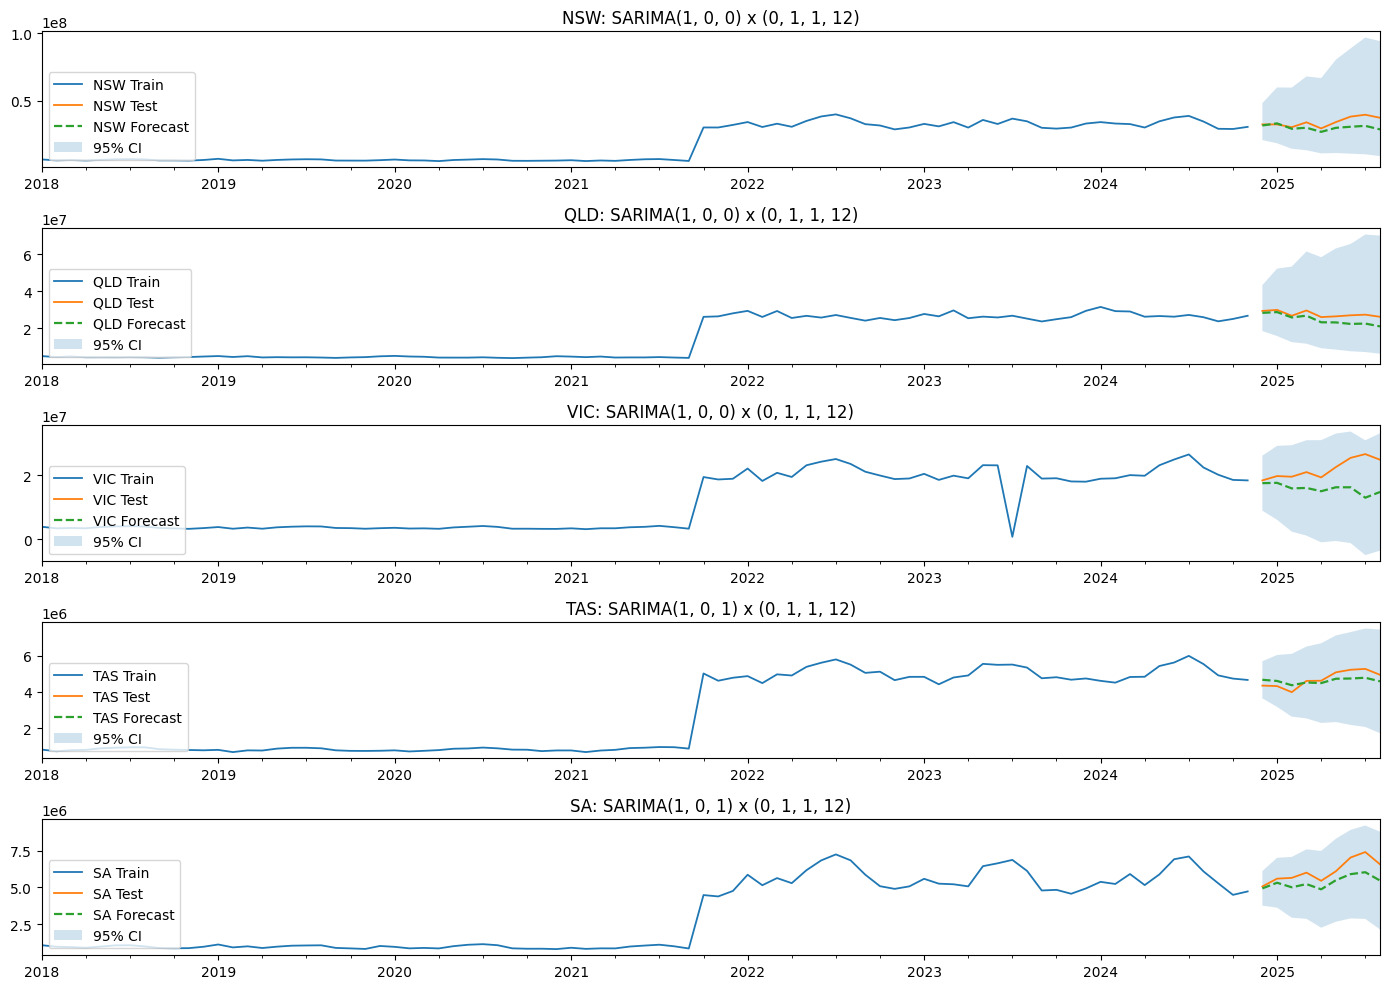

In [38]:
fig, axes = plt.subplots(5, 1, figsize=(14, 10), sharex=False)
for ax, region in zip(axes, ["NSW","QLD","VIC", "TAS", "SA"]):
    y_tr = to_series(train_dict[region])
    y_te = to_series(test_dict[region], like=best_fits[region]["fc"])
    fc   = best_fits[region]["fc"]
    ci   = best_fits[region]["ci"]

    y_tr.plot(ax=ax, label=f"{region} Train", lw=1.3)
    y_te.plot(ax=ax, label=f"{region} Test",  lw=1.3)
    fc.plot(ax=ax,   label=f"{region} Forecast", lw=1.6, ls='--')
    if isinstance(ci, pd.DataFrame) and set(['lower','upper']).issubset(ci.columns):
        ax.fill_between(fc.index, ci['lower'], ci['upper'], alpha=0.2, label="95% CI")

    ax.set_title(f"{region}: SARIMA{best_orders[region]['order']} x {best_orders[region]['seasonal']}")
    ax.legend(loc="lower left")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()


NSW mean(resid)=1212154.379, std=4324752.351
ARCH p-value: 0.40747678601515125
LB(1..24) p-value: 0.8649259111254882


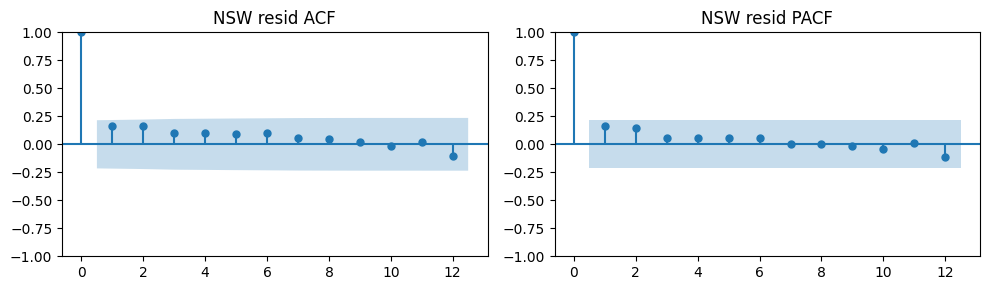


QLD mean(resid)=953472.360, std=3566587.935
ARCH p-value: 0.714844206676682
LB(1..24) p-value: 0.9777058678313267


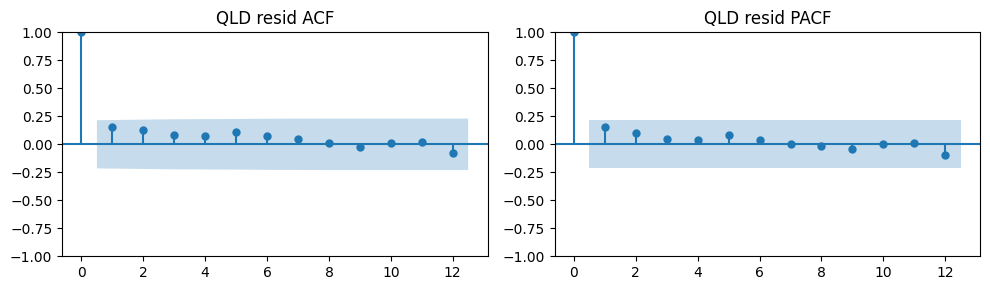


VIC mean(resid)=1220310.192, std=4219298.542
ARCH p-value: 0.16289113143776862
LB(1..24) p-value: 0.05257563358868255


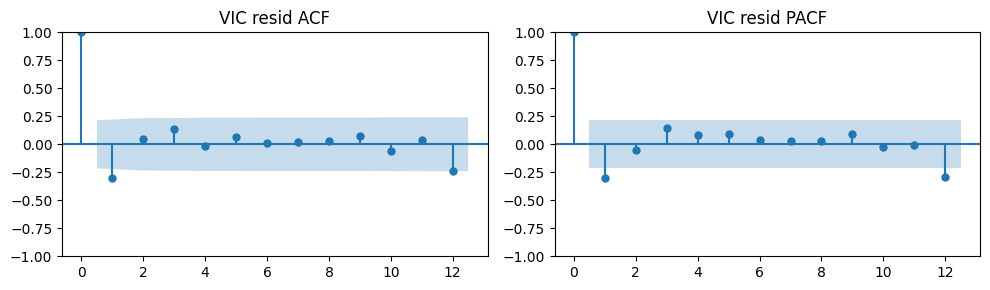


TAS mean(resid)=179649.817, std=577510.734
ARCH p-value: 0.9999999470346157
LB(1..24) p-value: 0.6927119977368196


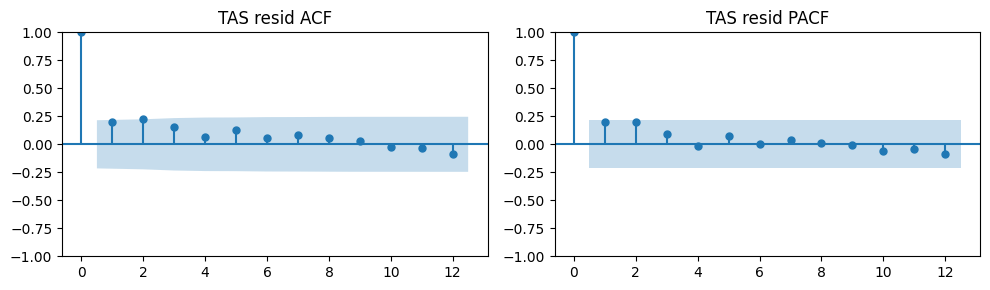


SA mean(resid)=200523.139, std=646331.279
ARCH p-value: 0.9978604210344453
LB(1..24) p-value: 0.287295960521348


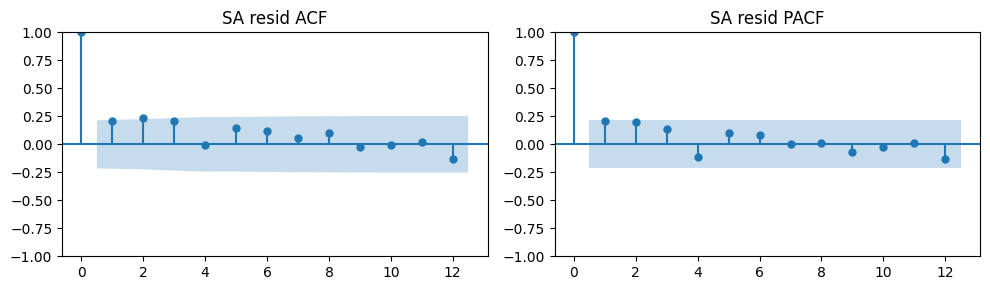

In [39]:
for r in ["NSW","QLD","VIC", 'TAS', "SA"]:
    resid = best_fits[r]["resid_orig"].dropna()
    print(f"\n{r} mean(resid)={resid.mean():.3f}, std={resid.std():.3f}")
    print("ARCH p-value:", het_arch(resid, nlags=12)[1])   # >0.05 ⇒ no strong ARCH
    print("LB(1..24) p-value:", acorr_ljungbox(resid, lags=[24], return_df=True)["lb_pvalue"].iloc[-1])

    fig, ax = plt.subplots(1,2, figsize=(10,3))
    plot_acf(resid, lags=12, ax=ax[0]); ax[0].set_title(f"{r} resid ACF")
    plot_pacf(resid, lags=12, ax=ax[1]); ax[1].set_title(f"{r} resid PACF")
    plt.tight_layout(); plt.show()


# Regression model

In [40]:
REPO = Path("/Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7")  # or wherever STDS-GROUP7 lives
WEATHER = REPO / "data" / "weather" / "avg_weather_20180101_20250911.csv"

print("Reading:", WEATHER.resolve())
weather_data = pd.read_csv(WEATHER)
weather_data.tail()

Reading: /Users/linh/Documents/36103 Statistical Thinking for Data Science /Assignment 2/stds-group7/data/weather/avg_weather_20180101_20250911.csv


,state,YYYY-MM-DD,daily_rain,max_temp,min_temp,radiation,rh_tmax,rh_tmin
14050,TAS,2025-09-07,1.87,15.12,4.46,5.16,57.38,99.66
14051,TAS,2025-09-08,13.71,16.03,8.52,12.04,65.74,96.99
14052,TAS,2025-09-09,4.97,12.48,5.16,13.01,51.53,83.12
14053,TAS,2025-09-10,0.48,13.36,2.86,14.03,49.72,95.68
14054,TAS,2025-09-11,0.21,14.43,4.36,13.94,50.77,95.25


In [41]:
weather_data['rh_mean'] = (weather_data['rh_tmax'] + weather_data['rh_tmin']) / 2 #since they are highly correlated -> we make the average the feature
weather_data['mean_temp'] = (weather_data['max_temp'] + weather_data['min_temp']) / 2
weather_data.drop(columns=['max_temp', 'min_temp', 'rh_tmax', 'rh_tmin'], inplace=True) 

In [42]:
# Process weather data to monthly frequency
wd = weather_data.copy()
wd['date'] = pd.to_datetime(wd['YYYY-MM-DD'])
w_m = (wd.groupby(["state", pd.Grouper(key="date", freq="M")])
         .agg(rain=("daily_rain", "sum"),
              mean_temp=("mean_temp", "mean"),
              radiation=("radiation", "mean"),
              rh_mean=("rh_mean", "mean"))
         .reset_index()
         .rename(columns={"date": "MONTH_END"}))
w_m["ym"] = w_m["MONTH_END"].dt.to_period("M")
w_m = w_m.sort_values(["state", "ym"])

In [43]:
merged_datasets = []
datasets = [("NSW", NSW_data), ("QLD", QLD_data), ("VIC", VIC_data), ("TAS", TAS_data), ("SA", SA_data)]
wd = weather_data.copy()
wd['date'] = pd.to_datetime(wd['YYYY-MM-DD'])
w_m = (wd.groupby(["state", pd.Grouper(key="date", freq="M")])
         .agg(rain=("daily_rain", "sum"),
              mean_temp=("mean_temp", "mean"),
              radiation=("radiation", "mean"),
              rh_mean=("rh_mean", "mean"))
         .reset_index()
         .rename(columns={"date": "MONTH_END"}))
w_m["ym"] = w_m["MONTH_END"].dt.to_period("M")
w_m = w_m.sort_values(["state", "ym"])

for state, df in datasets:
    # Convert SETTLEMENTDATE to datetime
    df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
    df.sort_values('SETTLEMENTDATE', inplace=True)

    # Extract time-based features
    d = df['SETTLEMENTDATE']
    df['Year'] = d.dt.year
    df['Month'] = d.dt.month
    df['Quarter'] = d.dt.quarter
    df['DaysInMonth'] = d.dt.days_in_month

    # Aggregate energy data to monthly frequency
    monthly_df = df.groupby(['Year', 'Month']).agg({
        'TOTALDEMAND': 'sum',  # Avg total demand for the month
        'RRP': 'mean',         # Average RRP for the month
        'REGION': 'first',     # Keep the region (should be consistent within state)
        'Quarter': 'first',    # Take the first quarter of the month
        'DaysInMonth': 'first' # Take the days in month (consistent within month)
    }).reset_index()

    monthly_df['TOTALDEMAND'] = monthly_df['TOTALDEMAND'] * 0.5
    # Add holiday-related features
    years = range(int(monthly_df["Year"].min()), int(monthly_df["Year"].max()) + 1)
    hol = holidays.Australia(subdiv=state, years=years)
    hol_month = (
        pd.Series(1, index=pd.to_datetime(list(hol.keys())))
          .to_frame("is_hol")
          .assign(ym=lambda s: s.index.to_period("M"))
          .groupby("ym")["is_hol"].sum()
    )

    # Map holiday features to monthly energy data
    monthly_df["ym"] = pd.to_datetime(monthly_df[['Year', 'Month']].assign(day=1)).dt.to_period("M")
    monthly_df["HolidayCount"] = monthly_df["ym"].map(hol_month).fillna(0).astype(int)
    monthly_df["HolidayShare"] = monthly_df["HolidayCount"] / monthly_df["DaysInMonth"]

    # Calculate months since start of dataset
    monthly_df["t"] = ((monthly_df["Year"] - monthly_df["Year"].min()) * 12 + 
                       (monthly_df["Month"] - monthly_df["Month"].min()))

    # Drop temporary columns from energy data
    monthly_df.drop(columns=['DaysInMonth'], inplace=True)

    # Merge with weather data for the current state
    state_weather = w_m[w_m['state'] == state].copy()
    merged_df = monthly_df.merge(
        state_weather[['state', 'ym', 'rain', 'mean_temp', 'radiation', 'rh_mean']],
        left_on=['ym'],
        right_on=['ym'],
        how='left'
    )

    # Drop redundant columns and ensure state consistency
    merged_df['REGION'] = state  # Ensure REGION is set to the state
    merged_df.drop(columns=['ym'], inplace=True, errors='ignore')

    # Store the merged DataFrame
    merged_datasets.append((state, merged_df))

    # Print DataFrame info
    print(f'{state} information{"-"*30}')
    merged_df.info()

NSW information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          93 non-null     int32  
 1   Month         93 non-null     int32  
 2   TOTALDEMAND   93 non-null     float64
 3   RRP           93 non-null     float64
 4   REGION        93 non-null     object 
 5   Quarter       93 non-null     int32  
 6   HolidayCount  93 non-null     int64  
 7   HolidayShare  93 non-null     float64
 8   t             93 non-null     int32  
 9   state         93 non-null     object 
 10  rain          93 non-null     float64
 11  mean_temp     93 non-null     float64
 12  radiation     93 non-null     float64
 13  rh_mean       93 non-null     float64
dtypes: float64(7), int32(4), int64(1), object(2)
memory usage: 8.8+ KB
QLD information------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIn

In [44]:
drop_cols = ["TOTALDEMAND"]  # don't drop SETTLEMENTDATE since monthly_df has Year/Month instead

train_cutoff = pd.to_datetime("2024-12-31")
test_end     = pd.to_datetime("2025-09-01")

for state, region_df in merged_datasets:  # <-- use merged_datasets here
    df = region_df.copy().sort_values(["Year","Month"])
    df["date"] = pd.to_datetime(df[["Year","Month"]].assign(day=1))
    df = df.set_index("date")

    train_df = df.loc[:train_cutoff]
    test_df  = df.loc[train_cutoff+pd.Timedelta(days=1):test_end]

    globals()[f"{state}_X_tr"] = train_df.drop(columns=drop_cols, errors="ignore")
    globals()[f"{state}_y_tr"] = train_df["TOTALDEMAND"]

    globals()[f"{state}_X_te"] = test_df.drop(columns=drop_cols, errors="ignore")
    globals()[f"{state}_y_te"] = test_df["TOTALDEMAND"]

    print(f"Created {state}_X_tr, {state}_y_tr, {state}_X_te, {state}_y_te")


Created NSW_X_tr, NSW_y_tr, NSW_X_te, NSW_y_te
Created QLD_X_tr, QLD_y_tr, QLD_X_te, QLD_y_te
Created VIC_X_tr, VIC_y_tr, VIC_X_te, VIC_y_te
Created TAS_X_tr, TAS_y_tr, TAS_X_te, TAS_y_te
Created SA_X_tr, SA_y_tr, SA_X_te, SA_y_te


In [45]:
X_train_df = [("NSW", NSW_X_tr), ("QLD", QLD_X_tr), ("VIC", VIC_X_tr), ("TAS", TAS_X_tr), ("SA", SA_X_tr)]
y_train_df = [("NSW", NSW_y_tr), ("QLD", QLD_y_tr), ("VIC", VIC_y_tr), ("TAS", TAS_y_tr), ("SA", SA_y_tr)]
X_test_df  = [("NSW", NSW_X_te), ("QLD", QLD_X_te), ("VIC", VIC_X_te), ("TAS", TAS_X_te), ("SA", SA_X_te)]
y_test_df  = [("NSW", NSW_y_te), ("QLD", QLD_y_te), ("VIC", VIC_y_te), ("TAS", TAS_y_te), ("SA", SA_y_te)]

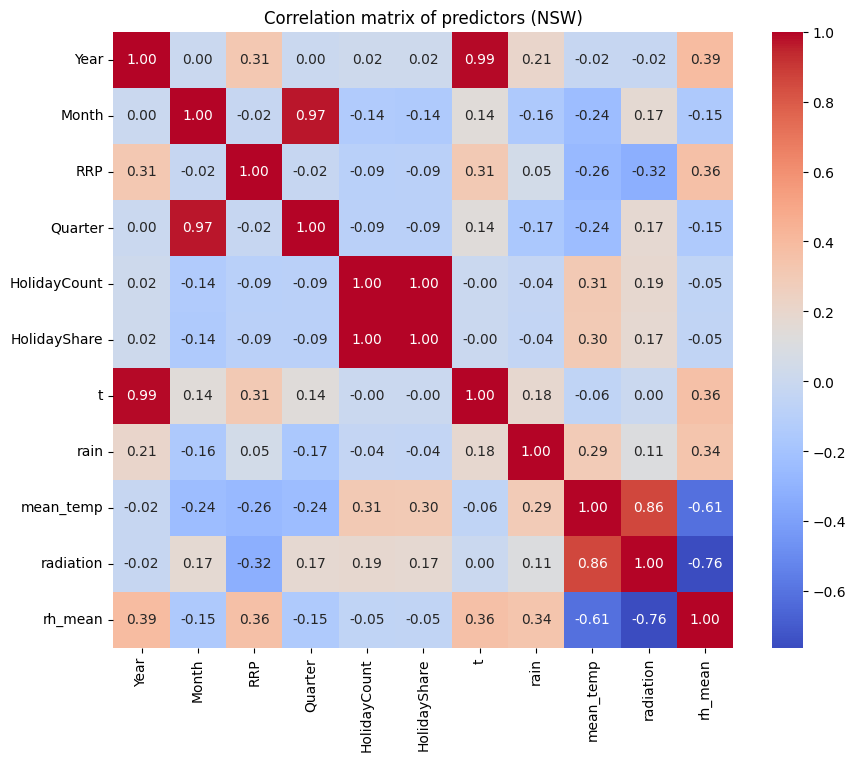

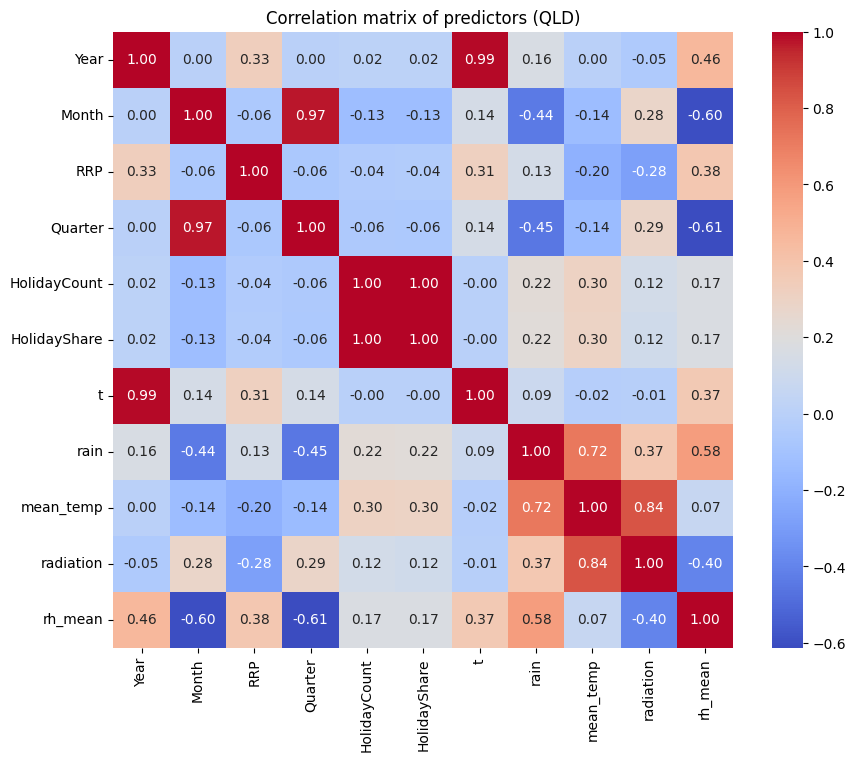

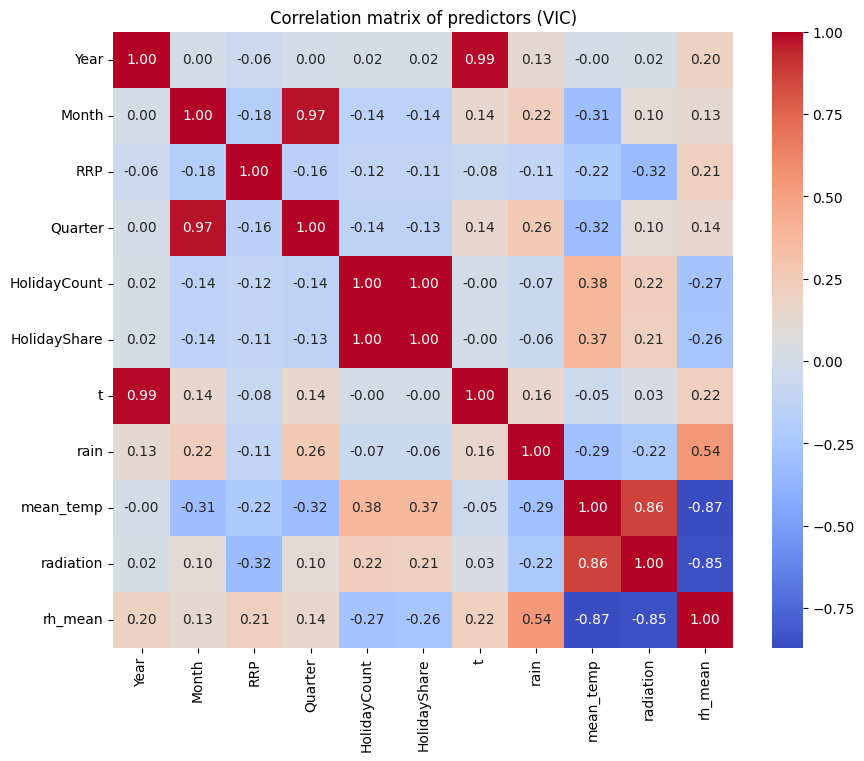

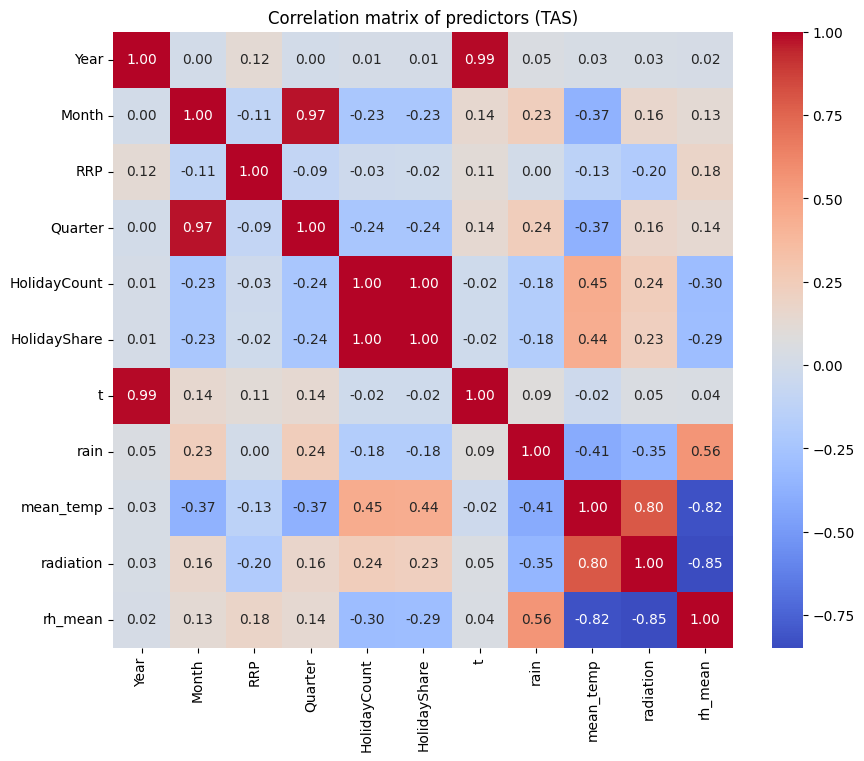

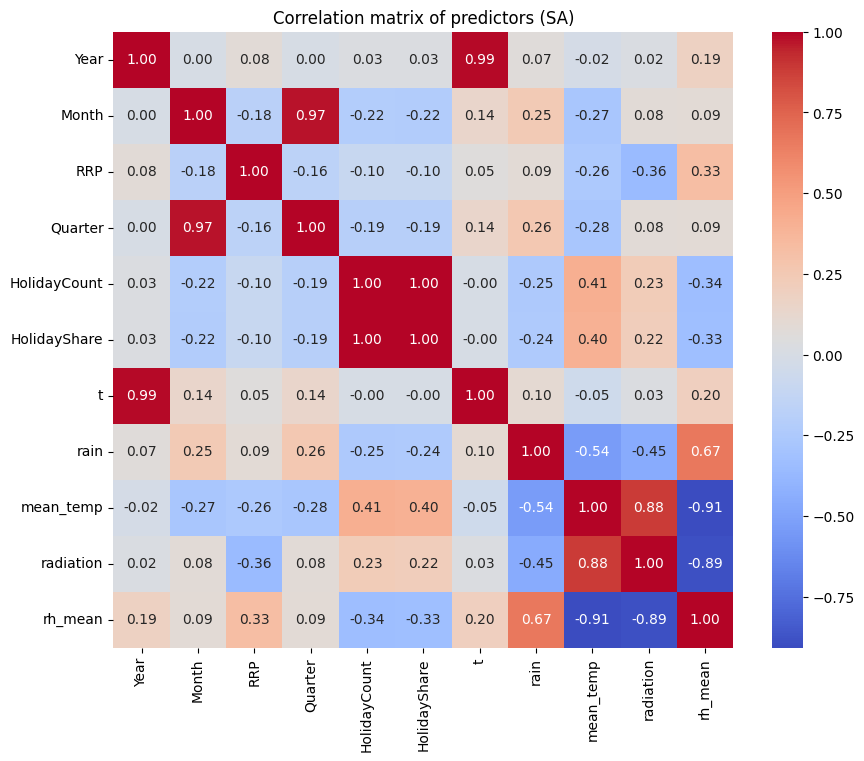

In [46]:
for name, df in X_train_df:
    X_corr = df.copy()
    X_corr = X_corr.select_dtypes(include="number")

    plt.figure(figsize=(10,8))
    sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Correlation matrix of predictors ({name})")
    plt.show()


- All datasets have correlation between (Year, t), (Month, Quarter), (Mean temp, Radiation), (mean temp, rh_mean), (radiation, rh_mean)

--> Keep trend (t), Holidayshare, Month

In [47]:
def compute_vif(df, features):
    X = df[features].dropna()
    vif_data = []
    for i, col in enumerate(X.columns):
        vif = variance_inflation_factor(X.values, i)
        vif_data.append((col, vif))
    return pd.DataFrame(vif_data, columns=["feature", "VIF"])

In [48]:
datasets = {state: df for state, df in merged_datasets}

num_features = [
    "RRP","HolidayShare","t", 'HolidayCount',
    "rain","mean_temp","radiation","rh_mean"]

for name, dataset in datasets.items(): 
    vif_df = compute_vif(dataset, num_features)
    print(f"\n{name} VIFs:")
    print(vif_df.sort_values("VIF", ascending=False))



NSW VIFs:
        feature          VIF
3  HolidayCount  6497.000769
1  HolidayShare  6459.476483
5     mean_temp    60.264462
6     radiation    57.651695
7       rh_mean    21.287689
4          rain     5.471236
2             t     4.728541
0           RRP     4.367482

QLD VIFs:
        feature          VIF
3  HolidayCount  5622.503465
1  HolidayShare  5591.085289
5     mean_temp   524.623325
6     radiation   247.436862
7       rh_mean    81.818563
4          rain     8.809107
2             t     4.971981
0           RRP     4.135558

VIC VIFs:
        feature          VIF
3  HolidayCount  5937.818815
1  HolidayShare  5886.770368
5     mean_temp    49.930866
6     radiation    35.729999
7       rh_mean    28.708107
4          rain     6.926195
2             t     4.085049
0           RRP     3.578233

TAS VIFs:
        feature          VIF
3  HolidayCount  6180.359172
1  HolidayShare  6132.957440
5     mean_temp    55.422336
7       rh_mean    41.228517
6     radiation    22.396153

**Dropping variables**
- Year
- Holiday count
- Quarter
- rh_mean, mean_temp, radiation: Use PCA to reduce correlation

In [49]:
drop_cols = ['Year', 'Quarter', 'HolidayCount']

X_train_drop, X_test_drop = [], []

for (name, X_tr), (_, X_te) in zip(X_train_df, X_test_df):
    X_tr = X_tr.drop(columns=[c for c in drop_cols if c in X_tr.columns], errors="ignore")
    X_te = X_te.drop(columns=[c for c in drop_cols if c in X_te.columns], errors="ignore")
    
    X_train_drop.append((name, X_tr))
    X_test_drop.append((name, X_te))

X_train_df = X_train_drop
X_test_df  = X_test_drop

In [50]:
weather_cols = ['mean_temp', 'radiation', 'rh_mean']
X_train_proc, X_test_proc = [], []

for (name, X_tr), (_, X_te) in zip(X_train_df, X_test_df):
    available_weather = [c for c in weather_cols if c in X_tr.columns]
    if len(available_weather) > 1:
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr[available_weather].fillna(0))

        pca = PCA(n_components=1, random_state=42)
        pcs_train = pca.fit_transform(X_tr_scaled)

        # Apply same transformation to test
        X_te_scaled = scaler.transform(X_te[available_weather].fillna(0))
        pcs_test = pca.transform(X_te_scaled)

        for i in range(1):
            X_tr[f"weather_PC{i+1}"] = pcs_train[:, i]
            X_te[f"weather_PC{i+1}"] = pcs_test[:, i]

        # Drop original weather cols
        X_tr = X_tr.drop(columns=available_weather)
        X_te = X_te.drop(columns=available_weather)

        print(f"{name}: explained variance by {1} PC(s) = {pca.explained_variance_ratio_.sum():.2%}")

    X_train_proc.append((name, X_tr))
    X_test_proc.append((name, X_te))

# Now you have updated lists like your original
X_train_df = X_train_proc
X_test_df  = X_test_proc

NSW: explained variance by 1 PC(s) = 83.01%
QLD: explained variance by 1 PC(s) = 63.40%
VIC: explained variance by 1 PC(s) = 90.73%
TAS: explained variance by 1 PC(s) = 88.13%
SA: explained variance by 1 PC(s) = 92.84%


In [51]:
num_features = ["RRP","HolidayShare","t","rain", 'weather_PC1']
for name, X_tr in X_train_df: 
    vif_df = compute_vif(X_tr, num_features)
    print(f"\n{name} VIFs:")
    print(vif_df.sort_values("VIF", ascending=False))



NSW VIFs:
        feature       VIF
2             t  3.870913
0           RRP  3.335744
3          rain  2.907972
1  HolidayShare  1.430870
4   weather_PC1  1.157374

QLD VIFs:
        feature       VIF
0           RRP  3.612992
2             t  3.208159
3          rain  3.086977
1  HolidayShare  1.578442
4   weather_PC1  1.450918

VIC VIFs:
        feature       VIF
3          rain  3.756121
2             t  3.308330
0           RRP  2.211932
1  HolidayShare  1.767574
4   weather_PC1  1.236903

TAS VIFs:
        feature       VIF
3          rain  3.712388
2             t  3.440585
0           RRP  2.651323
1  HolidayShare  1.692226
4   weather_PC1  1.334981

SA VIFs:
        feature       VIF
2             t  3.095616
3          rain  3.029043
0           RRP  2.418299
1  HolidayShare  1.675184
4   weather_PC1  1.482487


**No multicollinearity (all VIF < 5)**

## OLS

In [52]:
def eval_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

def run_ols(train_df, test_df, y_col="TOTALDEMAND"):
    """
    Run OLS with Month categorical.
    """
    base = ["RRP", "HolidayShare", "t", "rain", "weather_PC1"]

    formula = f"{y_col} ~ " + " + ".join(base) + " + C(Month)"
    model = smf.ols(formula=formula, data=train_df).fit()

    pred = model.predict(test_df)

    rmse, mae = eval_metrics(test_df[y_col], pred)
    r2 = model.rsquared
    return model, pred, rmse, mae, r2

In [53]:
models_month   = {}
preds_month    = {}
results = []

for (region, X_tr), (_, y_tr), (_, X_te), (_, y_te) in zip(X_train_df, y_train_df, X_test_df, y_test_df):
    train_df = X_tr.copy()
    train_df["TOTALDEMAND"] = y_tr

    test_df = X_te.copy()
    test_df["TOTALDEMAND"] = y_te

    m_month, pred_month, rmse_m, mae_m, r2_m = run_ols(train_df, test_df)
    models_month[region] = m_month
    preds_month[region]  = (y_te, pred_month)

    results.append({
        "Region": region,
        "RMSE": rmse_m,
        "MAE": mae_m,
        "R2":  r2_m
    })

results_df = pd.DataFrame(results)
results_df

,Region,RMSE,MAE,R2
0,NSW,1.378785e+07,7.739109e+06,0.804197
1,QLD,1.106386e+07,6.375810e+06,0.826779
2,VIC,9.687510e+06,5.540478e+06,0.771216
3,TAS,2.559823e+06,2.161369e+06,0.812126
4,SA,2.656036e+06,1.341316e+06,0.839281


Not very good at all -> very high RMSE,MAE and super low R2

==> A way to make it better is to add lag. Since demand at a given time is highly dependent on its own recent history, so including lag terms provides the model with “memory” of past consumption. 

## OLS with lags

In [54]:
def add_lags_full(X, y, lags=[1,2,3], cutoff=None):
    df = X.copy()
    for l in lags:
        df[f"lag_{l}"] = y.shift(l)
    df = df.dropna()
    y_new = y.loc[df.index]

    if cutoff is not None:
        train_mask = df.index <= cutoff
        X_tr, y_tr = df.loc[train_mask], y_new.loc[train_mask]
        X_te, y_te = df.loc[~train_mask], y_new.loc[~train_mask]
        return X_tr, y_tr, X_te, y_te

    return df, y_new


In [55]:
X_train_lags, y_train_lags = [], []
X_test_lags,  y_test_lags  = [], []

for (region, X_tr), (_, y_tr), (_, X_te), (_, y_te) in zip(X_train_df, y_train_df, X_test_df, y_test_df):
    X_full = pd.concat([X_tr, X_te])
    y_full = pd.concat([y_tr, y_te])

    X_tr_lag, y_tr_lag, X_te_lag, y_te_lag = add_lags_full(X_full, y_full, lags=[1,2,3], cutoff=y_tr.index.max())

    X_train_lags.append((region, X_tr_lag))
    y_train_lags.append((region, y_tr_lag))
    X_test_lags.append((region, X_te_lag))
    y_test_lags.append((region, y_te_lag))


In [56]:
def run_ols(train_df, test_df, y_col='TOTALDEMAND', use_lags=False):
    base = ["RRP", "HolidayShare", "t", "rain", "weather_PC1"]
    features = base + ["C(Month)"]

    if use_lags:
        for lag in [1,2,3]:
            lag_col = f"lag_{lag}"
            if lag_col in train_df.columns:
                features.append(lag_col)

    formula = f'{y_col} ~ ' + ' + '.join(features)
    model = smf.ols(formula=formula, data=train_df).fit()
    pred = model.predict(test_df)
    rmse, mae = eval_metrics(test_df[y_col], pred)
    r2 = model.rsquared
    return model, pred, rmse, mae, r2


In [57]:
results = []

for (region, X_tr), (_, y_tr), (_, X_te), (_, y_te) in zip(X_train_lags, y_train_lags, X_test_lags, y_test_lags):
    train_df = X_tr.copy(); train_df["TOTALDEMAND"] = y_tr
    test_df  = X_te.copy(); test_df["TOTALDEMAND"]  = y_te

    m, pred, rmse, mae, r2 = run_ols(train_df, test_df, use_lags=True)

    results.append({"Region": region, "RMSE": rmse, "MAE": mae, "R2": r2})

results_df = pd.DataFrame(results).set_index("Region")
results_df

,RMSE,MAE,R2
Region,,,
NSW,1.219852e+07,5.573511e+06,0.959101
QLD,8.592166e+06,3.894254e+06,0.959616
VIC,9.088497e+06,4.343162e+06,0.860142
TAS,1.575749e+06,6.726923e+05,0.960760
SA,2.124775e+06,9.341101e+05,0.959921


In [58]:
from sklearn.metrics import r2_score

def run_ols(train_df, test_df, y_col="TOTALDEMAND", lag_list=None, use_month=True):
    base = ["RRP", "HolidayShare", "t", "rain", "weather_PC1"]
    features = base.copy()
    if use_month and "Month" in train_df.columns:
        features.append("C(Month)")

    if lag_list is None:
        lag_list = []

    for lag in lag_list:
        lag_col = f"lag_{lag}"
        if lag_col in train_df.columns:
            features.append(lag_col)

    formula = f"{y_col} ~ " + " + ".join(features)
    model = smf.ols(formula=formula, data=train_df).fit()

    pred = model.predict(test_df)
    df_eval = pd.DataFrame({"y_true": test_df[y_col], "y_pred": pred}).dropna()

    if df_eval.empty:
        print("⚠️ Warning: No valid rows left for evaluation.")
        return model, [], [], np.nan, np.nan, np.nan

    rmse, mae = eval_metrics(df_eval["y_true"], df_eval["y_pred"])
    r2 = model.rsquared

    return model, df_eval["y_true"], df_eval["y_pred"], rmse, mae, r2


In [59]:
lag_strategies = {
    "Lag1": [1],
    "Lag2": [2],
    "Lag3": [3],
    "Lag1,2": [1, 2],       
    "Lag1,2,3": [1, 2, 3],
    "Lag12": [12]
}

results = []
fitted_models = {}

for name, lags in lag_strategies.items():
    for (region, X_tr), (_, y_tr), (_, X_te), (_, y_te) in zip(X_train_lags, y_train_lags, X_test_lags, y_test_lags):
        
        train_df = X_tr.copy(); train_df["TOTALDEMAND"] = y_tr
        test_df  = X_te.copy(); test_df["TOTALDEMAND"]  = y_te

        m, y_true, y_pred, rmse, mae, r2 = run_ols(train_df, test_df, lag_list=lags, use_month=True)

        # store the model by region and lag spec
        fitted_models[(region, name)] = m

        results.append({
            "Lag_Spec": name,
            "Region": region,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })

results_df = pd.DataFrame(results)

In [60]:
results_df

,Lag_Spec,Region,RMSE,MAE,R2
0,Lag1,NSW,1.216399e+07,5.516522e+06,0.957916
1,Lag1,QLD,8.560295e+06,3.770636e+06,0.959254
2,Lag1,VIC,9.033605e+06,4.356628e+06,0.848487
3,Lag1,TAS,1.561250e+06,6.613826e+05,0.959538
4,Lag1,SA,2.131040e+06,9.676514e+05,0.958523
5,Lag2,NSW,1.261615e+07,5.585956e+06,0.923255
6,Lag2,QLD,8.964181e+06,4.507280e+06,0.929180
7,Lag2,VIC,9.587735e+06,4.356742e+06,0.827019
8,Lag2,TAS,1.733438e+06,8.055410e+05,0.922635
9,Lag2,SA,2.336858e+06,1.021702e+06,0.921612


Model with lag 1 and lag1+2+3 have the best RMSE, MAE and R2

- Lag 1: last month's demand directly predicts this month's demand 

- Lag 1+2+3: This month’s demand is explained by a combination of the last three months’ (the quarter) demands, not just the immediately previous month

In [61]:
# Does having Month as category variable helps with lagged models?
strategies = {
    "MonthOnly": {"lags": None, "month": True},
    "LagsOnly":  {"lags": [1,2,3], "month": False},
    "Both":      {"lags": [1,2,3], "month": True}
}

results = []
for strat, cfg in strategies.items():
    total_se = 0.0
    total_ae = 0.0
    total_n  = 0

    for (region, X_tr), (_, y_tr), (_, X_te), (_, y_te) in zip(
        X_train_df, y_train_df, X_test_df, y_test_df
    ):
        train_df = X_tr.copy(); train_df["TOTALDEMAND"] = y_tr
        test_df  = X_te.copy(); test_df["TOTALDEMAND"]  = y_te

        m, y_true, y_pred, rmse, mae, r2 = run_ols(
            train_df, test_df,
            lag_list=cfg["lags"],
            use_month=cfg["month"]
        )

        n_obs = len(y_true)
        total_se += np.sum((y_true - y_pred) ** 2)
        total_ae += np.sum(np.abs(y_true - y_pred))
        total_n  += n_obs

        results.append({
            "Spec": strat,
            "Region": region,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        })

    # pooled weighted
    pooled_rmse = np.sqrt(total_se / total_n)
    pooled_mae  = total_ae / total_n
    results.append({
        "Spec": strat,
        "Region": "Overall (weighted)",
        "RMSE": pooled_rmse,
        "MAE": pooled_mae,
        "R2": np.nan
    })

results_df = pd.DataFrame(results)
results_df.pivot(index="Region", columns="Spec", values=["RMSE","MAE","R2"])

RMSE                                       MAE  \
Spec                        Both      LagsOnly     MonthOnly          Both   
Region                                                                       
NSW                 1.378785e+07  1.409209e+07  1.378785e+07  7.739109e+06   
Overall (weighted)  9.164812e+06  9.126891e+06  9.164812e+06  4.631616e+06   
QLD                 1.106386e+07  1.098619e+07  1.106386e+07  6.375810e+06   
SA                  2.656036e+06  2.638490e+06  2.656036e+06  1.341316e+06   
TAS                 2.559823e+06  2.595707e+06  2.559823e+06  2.161369e+06   
VIC                 9.687510e+06  9.138815e+06  9.687510e+06  5.540478e+06   

                                                      R2                      
Spec                    LagsOnly     MonthOnly      Both  LagsOnly MonthOnly  
Region                                                                        
NSW                 8.899428e+06  7.739109e+06  0.804197  0.788806  0.804197  
Overall (weighted)  5.012774e+06  4.631616e+06       NaN       NaN       NaN  
QLD                 6.790864e+06  6.375810e+06  0.826779  0.816166  0.826779  
SA                  1.510654e+06  1.341316e+06  0.839281  0.828331  0.839281  
TAS                 2.199359e+06  2.161369e+06  0.812126  0.804166  0.812126  
VIC                 5.663563e+06  5.540478e+06  0.771216  0.745076  0.771216

Since C(month) does not add any explanability and it makes the model even more complex --> monthly seasonality is already captured by autoregressive lag

==> So the final model will be "TOTALDEMAND ~ RRP + HolidayShare + t + rain + weather_PC1 + lag1 + lag2 + lag3"

In [62]:
fitted_models = {}

for (region, X_tr), (_, y_tr) in zip(X_train_df, y_train_df):
    df_tr = X_tr.copy()
    df_tr["TOTALDEMAND"] = y_tr

    # Adding lag1,2,3 as per previous analysis
    df_tr["lag1"] = df_tr["TOTALDEMAND"].shift(1)
    df_tr["lag2"] = df_tr["TOTALDEMAND"].shift(2)
    df_tr["lag3"] = df_tr["TOTALDEMAND"].shift(3)
    df_tr = df_tr.dropna()

    # standardise to plot coefficients
    features_to_scale = ["RRP", "HolidayShare", "t", "rain", "weather_PC1", "lag1", "lag2", "lag3"]
    scaler = StandardScaler()
    df_tr[features_to_scale] = scaler.fit_transform(df_tr[features_to_scale])

    formula = "TOTALDEMAND ~ RRP + HolidayShare + t + rain + weather_PC1 + lag1 + lag2 + lag3"
    model = smf.ols(formula=formula, data=df_tr).fit()

    fitted_models[region] = {"model": model, "scaler": scaler}

    print(f"--- {region} ---")
    print(model.summary())
    print()


--- NSW ---
                            OLS Regression Results                            
Dep. Variable:            TOTALDEMAND   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     158.3
Date:                Wed, 17 Sep 2025   Prob (F-statistic):           1.57e-42
Time:                        15:12:35   Log-Likelihood:                -1327.2
No. Observations:                  81   AIC:                             2672.
Df Residuals:                      72   BIC:                             2694.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.872e+07   3.73e+05  

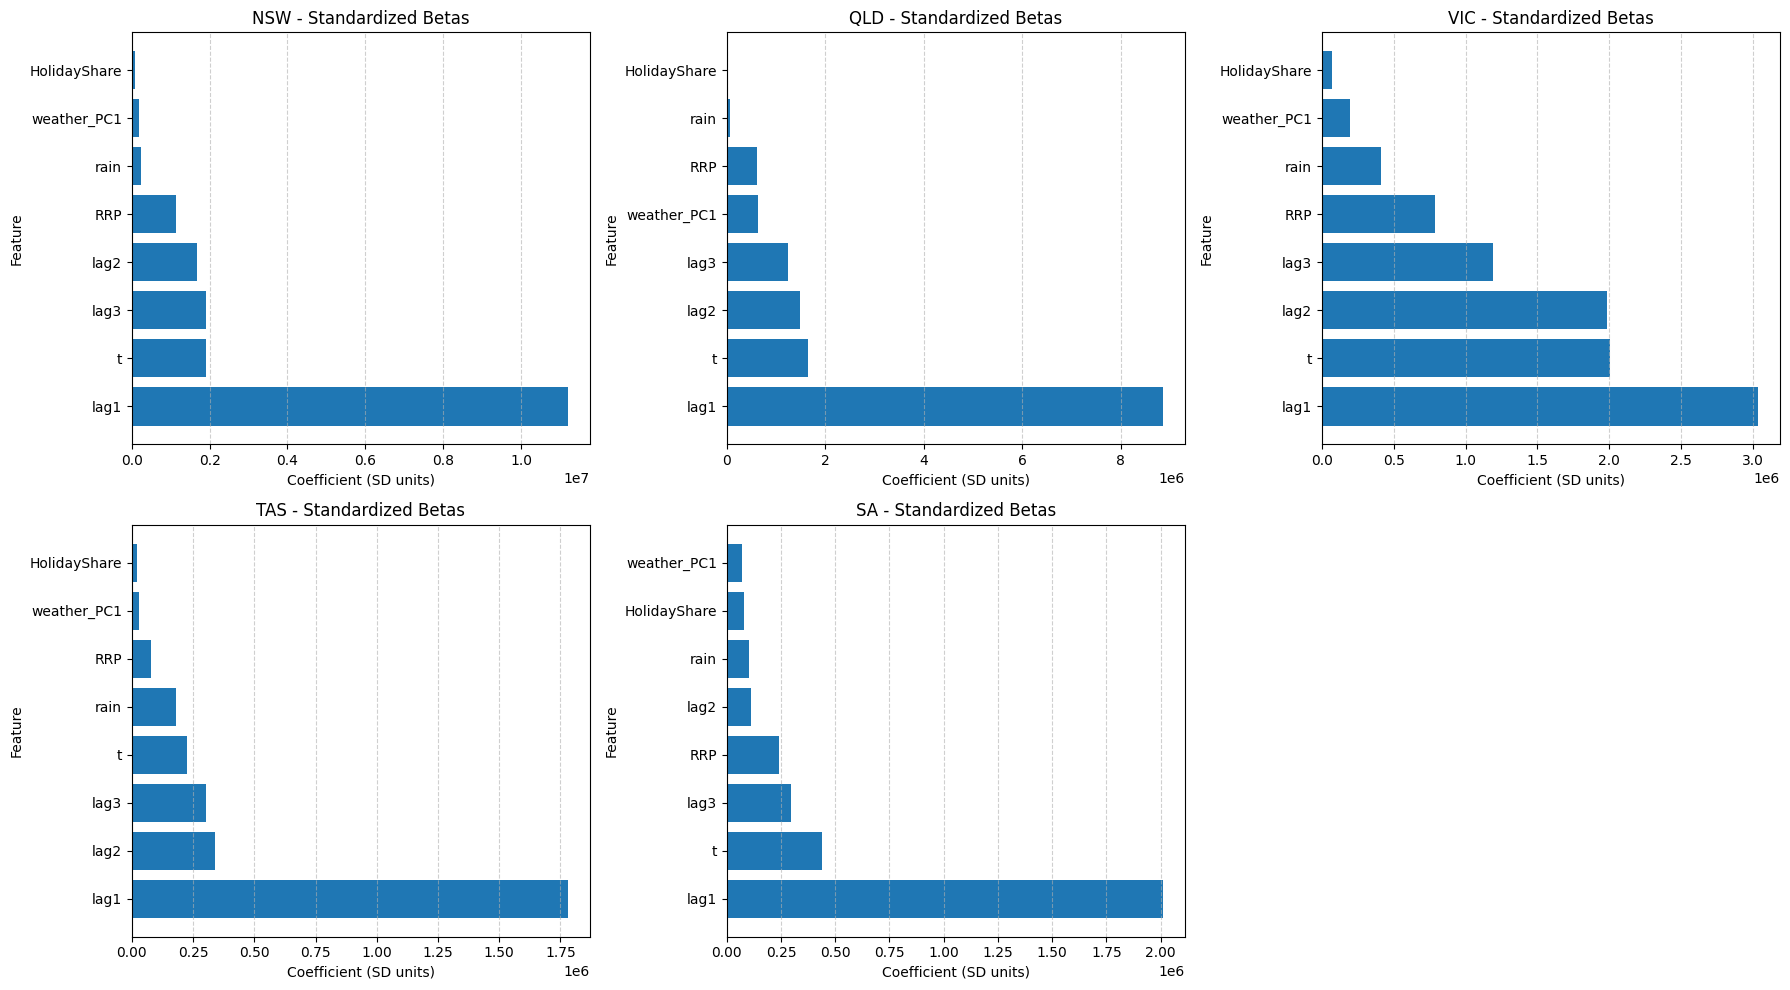

In [63]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

regions = list(fitted_models.keys())

for i, region in enumerate(regions):
    model = fitted_models[region]["model"]

    # Collect coefficients
    coefs = pd.DataFrame({
        "feature": model.params.index,
        "coef": np.abs(model.params.values)
    })
    coefs = coefs[coefs["feature"] != "Intercept"]

    # Sort by absolute value
    coefs = coefs.sort_values("coef", key=lambda x: abs(x), ascending=True)

    # Horizontal bar plot
    ax = axes[i]
    ax.barh(coefs["feature"], coefs["coef"])
    ax.set_title(f"{region} - Standardized Betas")
    ax.set_xlabel("Coefficient (SD units)")
    ax.set_ylabel("Feature")
    ax.grid(axis="x", linestyle="--", alpha=0.6)
    ax.invert_yaxis()

# Hide unused subplot(s) if fewer than 6 regions
for j in range(len(regions), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- NSW, VIC: Demand depends on last month’s usage, plus weather, holidays, and a clear upward trend.

- QLD: Similar to NSW/VIC, but weather/holiday effects are smaller.

- TAS, SA: Demand is mostly explained by last month’s demand — weather, holidays, and price barely matter.


### Final model (all dataset combined)

In [64]:
df_all = pd.concat([df for state, df in merged_datasets], ignore_index=True)

df_all.head()

,Year,Month,TOTALDEMAND,RRP,REGION,Quarter,HolidayCount,HolidayShare,t,state,rain,mean_temp,radiation,rh_mean
0,2018,1,6219977.770,76.028144,NSW,1,2,0.064516,0,NSW,48.08,24.443548,24.767742,60.374355
1,2018,2,5521163.395,72.795342,NSW,1,0,0.000000,1,NSW,67.17,22.859643,21.632500,62.022321
2,2018,3,5812928.960,66.701351,NSW,1,2,0.064516,2,NSW,59.05,21.110806,18.177419,65.336290
3,2018,4,5431874.065,75.138708,NSW,2,3,0.100000,3,NSW,27.77,18.971833,14.829333,66.325167
4,2018,5,5874759.805,77.266821,NSW,2,0,0.000000,4,NSW,23.24,12.716774,11.416129,69.951452


In [65]:
weather_feats = ["mean_temp", "radiation", "rh_mean"]
scaler = StandardScaler()
X_weather = scaler.fit_transform(df_all[weather_feats])

pca = PCA(n_components=1)
df_all["weather_PC1"] = pca.fit_transform(X_weather)

# Add lags for demand per region
for lag in [1, 2, 3]:
    df_all[f"lag{lag}"] = (
        df_all.groupby("REGION")["TOTALDEMAND"].shift(lag)
    )

# Drop rows with NaNs from lagging
df_all = df_all.dropna()

df_all.info()


<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 3 to 464
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          450 non-null    int32  
 1   Month         450 non-null    int32  
 2   TOTALDEMAND   450 non-null    float64
 3   RRP           450 non-null    float64
 4   REGION        450 non-null    object 
 5   Quarter       450 non-null    int32  
 6   HolidayCount  450 non-null    int64  
 7   HolidayShare  450 non-null    float64
 8   t             450 non-null    int32  
 9   state         450 non-null    object 
 10  rain          450 non-null    float64
 11  mean_temp     450 non-null    float64
 12  radiation     450 non-null    float64
 13  rh_mean       450 non-null    float64
 14  weather_PC1   450 non-null    float64
 15  lag1          450 non-null    float64
 16  lag2          450 non-null    float64
 17  lag3          450 non-null    float64
dtypes: float64(11), int32(4), int64(1),

In [66]:
df_all.head()

,Year,Month,TOTALDEMAND,RRP,REGION,Quarter,HolidayCount,HolidayShare,t,state,rain,mean_temp,radiation,rh_mean,weather_PC1,lag1,lag2,lag3
3,2018,4,5431874.065,75.138708,NSW,2,3,0.100000,3,NSW,27.77,18.971833,14.829333,66.325167,0.370675,5812928.960,5521163.395,6219977.770
4,2018,5,5874759.805,77.266821,NSW,2,0,0.000000,4,NSW,23.24,12.716774,11.416129,69.951452,-0.924241,5431874.065,5812928.960,5521163.395
5,2018,6,6300361.280,100.726375,NSW,2,1,0.033333,5,NSW,57.32,9.885500,9.467000,74.809833,-1.820743,5874759.805,5431874.065,5812928.960
6,2018,7,6452774.755,75.006499,NSW,3,0,0.000000,6,NSW,17.95,9.396452,11.145806,67.998387,-1.130913,6300361.280,5874759.805,5431874.065
7,2018,8,6237326.250,92.979429,NSW,3,0,0.000000,7,NSW,28.40,9.980806,13.316129,65.766774,-0.664233,6452774.755,6300361.280,5874759.805


In [67]:
if "date" not in df_all.columns:
    df_all["date"] = pd.to_datetime(df_all[["Year","Month"]].assign(day=1))

cutoff = pd.to_datetime("2025-01-01")
test_end = pd.to_datetime("2025-09-01")

train_df = df_all[df_all["date"] < cutoff].copy()
test_df  = df_all[(df_all["date"] >= cutoff) & (df_all["date"] < test_end)].copy()

train_df = train_df.set_index("date").sort_index()
test_df  = test_df.set_index("date").sort_index()


In [68]:
from sklearn.preprocessing import StandardScaler

# Scale X and y separately
X_cols = ["RRP", "HolidayShare", "rain", "weather_PC1", "lag1", "lag2", "lag3"]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on training data only
train_df[X_cols] = scaler_X.fit_transform(train_df[X_cols])
train_df["TOTALDEMAND"] = scaler_y.fit_transform(train_df[["TOTALDEMAND"]])

# Apply same transform to test
test_df[X_cols] = scaler_X.transform(test_df[X_cols])
test_df["TOTALDEMAND"] = scaler_y.transform(test_df[["TOTALDEMAND"]])


In [69]:
formula = "TOTALDEMAND ~ RRP + HolidayShare + rain + weather_PC1 + lag1 + lag2 + lag3 + C(REGION)"
pooled_model_std = smf.ols(formula=formula, data=train_df).fit()

print(pooled_model_std.summary())

                            OLS Regression Results                            
Dep. Variable:            TOTALDEMAND   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     596.4
Date:                Wed, 17 Sep 2025   Prob (F-statistic):          2.10e-237
Time:                        15:12:35   Log-Likelihood:                 7.1446
No. Observations:                 405   AIC:                             9.711
Df Residuals:                     393   BIC:                             57.76
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0440      0.029  

In [70]:
# Predictions on train/test
y_train_pred = pooled_model_std.predict(train_df)
y_test_pred  = pooled_model_std.predict(test_df)

# Inverse-transform to original scale
y_train_true = scaler_y.inverse_transform(train_df[["TOTALDEMAND"]]).ravel()
y_test_true  = scaler_y.inverse_transform(test_df[["TOTALDEMAND"]]).ravel()
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.values.reshape(-1,1)).ravel()
y_test_pred_orig  = scaler_y.inverse_transform(y_test_pred.values.reshape(-1,1)).ravel()

# Wrap back into Series with the right index
y_train_true = pd.Series(y_train_true, index=train_df.index, name="y_true")
y_test_true  = pd.Series(y_test_true,  index=test_df.index,  name="y_true")
y_train_pred_orig = pd.Series(y_train_pred_orig, index=train_df.index, name="y_pred")
y_test_pred_orig  = pd.Series(y_test_pred_orig,  index=test_df.index,  name="y_pred")

rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred_orig))
mae  = mean_absolute_error(y_test_true, y_test_pred_orig)

print(f"Test RMSE: {rmse}")
print(f"Test MAE : {mae}")

Test RMSE: 1840168.987790344
Test MAE : 1322154.6367166638


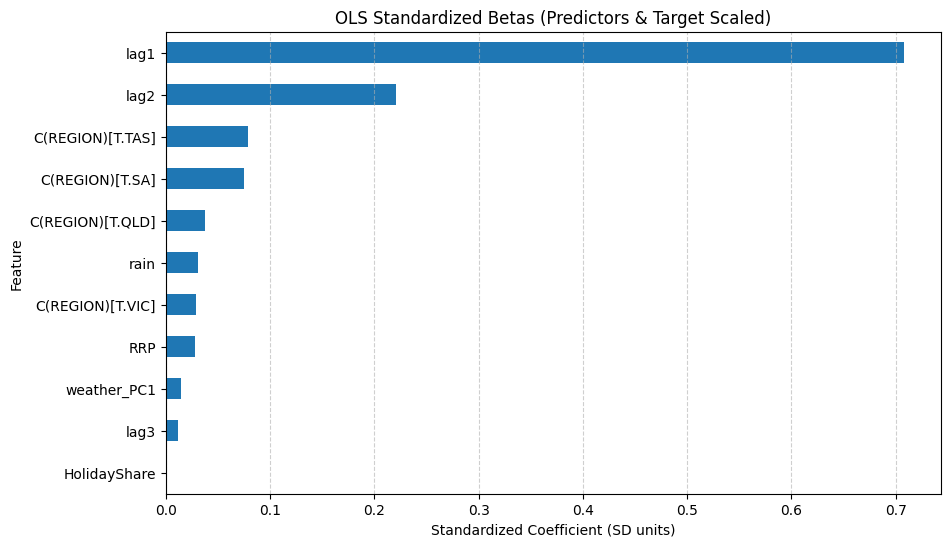

In [71]:
coefs = pooled_model_std.params.drop("Intercept", errors="ignore").sort_values(key=lambda x: abs(x), ascending=False)

plt.figure(figsize=(10,6))
np.abs(coefs).plot(kind="barh")
plt.title("OLS Standardized Betas (Predictors & Target Scaled)")
plt.xlabel("Standardized Coefficient (SD units)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

- Lagged demand (especially Lag 1 and Lag 2) is the strongest predictor → confirming high persistence and autocorrelation in electricity usage.

- State fixed effects (REGION dummies) dominate the model → electricity demand levels vary substantially across states.

- Weather, price (RRP), and holiday variables contribute only marginally once state and lag effects are controlled for.

==> For forecasting, the core model should prioritize region-specific demand history (lags). Weather and holiday effects may provide incremental gains but are secondary drivers compared to past demand.

In [72]:
# Get predictions with confidence intervals for test set
pred_test = pooled_model_std.get_prediction(test_df)
pred_summary = pred_test.summary_frame(alpha=0.05)  # 95% CI

# Extract
y_test_pred_ci = scaler_y.inverse_transform(pred_summary["mean"].values.reshape(-1,1)).ravel()
ci_lower = scaler_y.inverse_transform(pred_summary["obs_ci_lower"].values.reshape(-1,1)).ravel()
ci_upper = scaler_y.inverse_transform(pred_summary["obs_ci_upper"].values.reshape(-1,1)).ravel()

# Put into DataFrame aligned with test index
ci_df = pd.DataFrame({
    "pred": y_test_pred_ci,
    "lower": ci_lower,
    "upper": ci_upper
}, index=test_df.index)


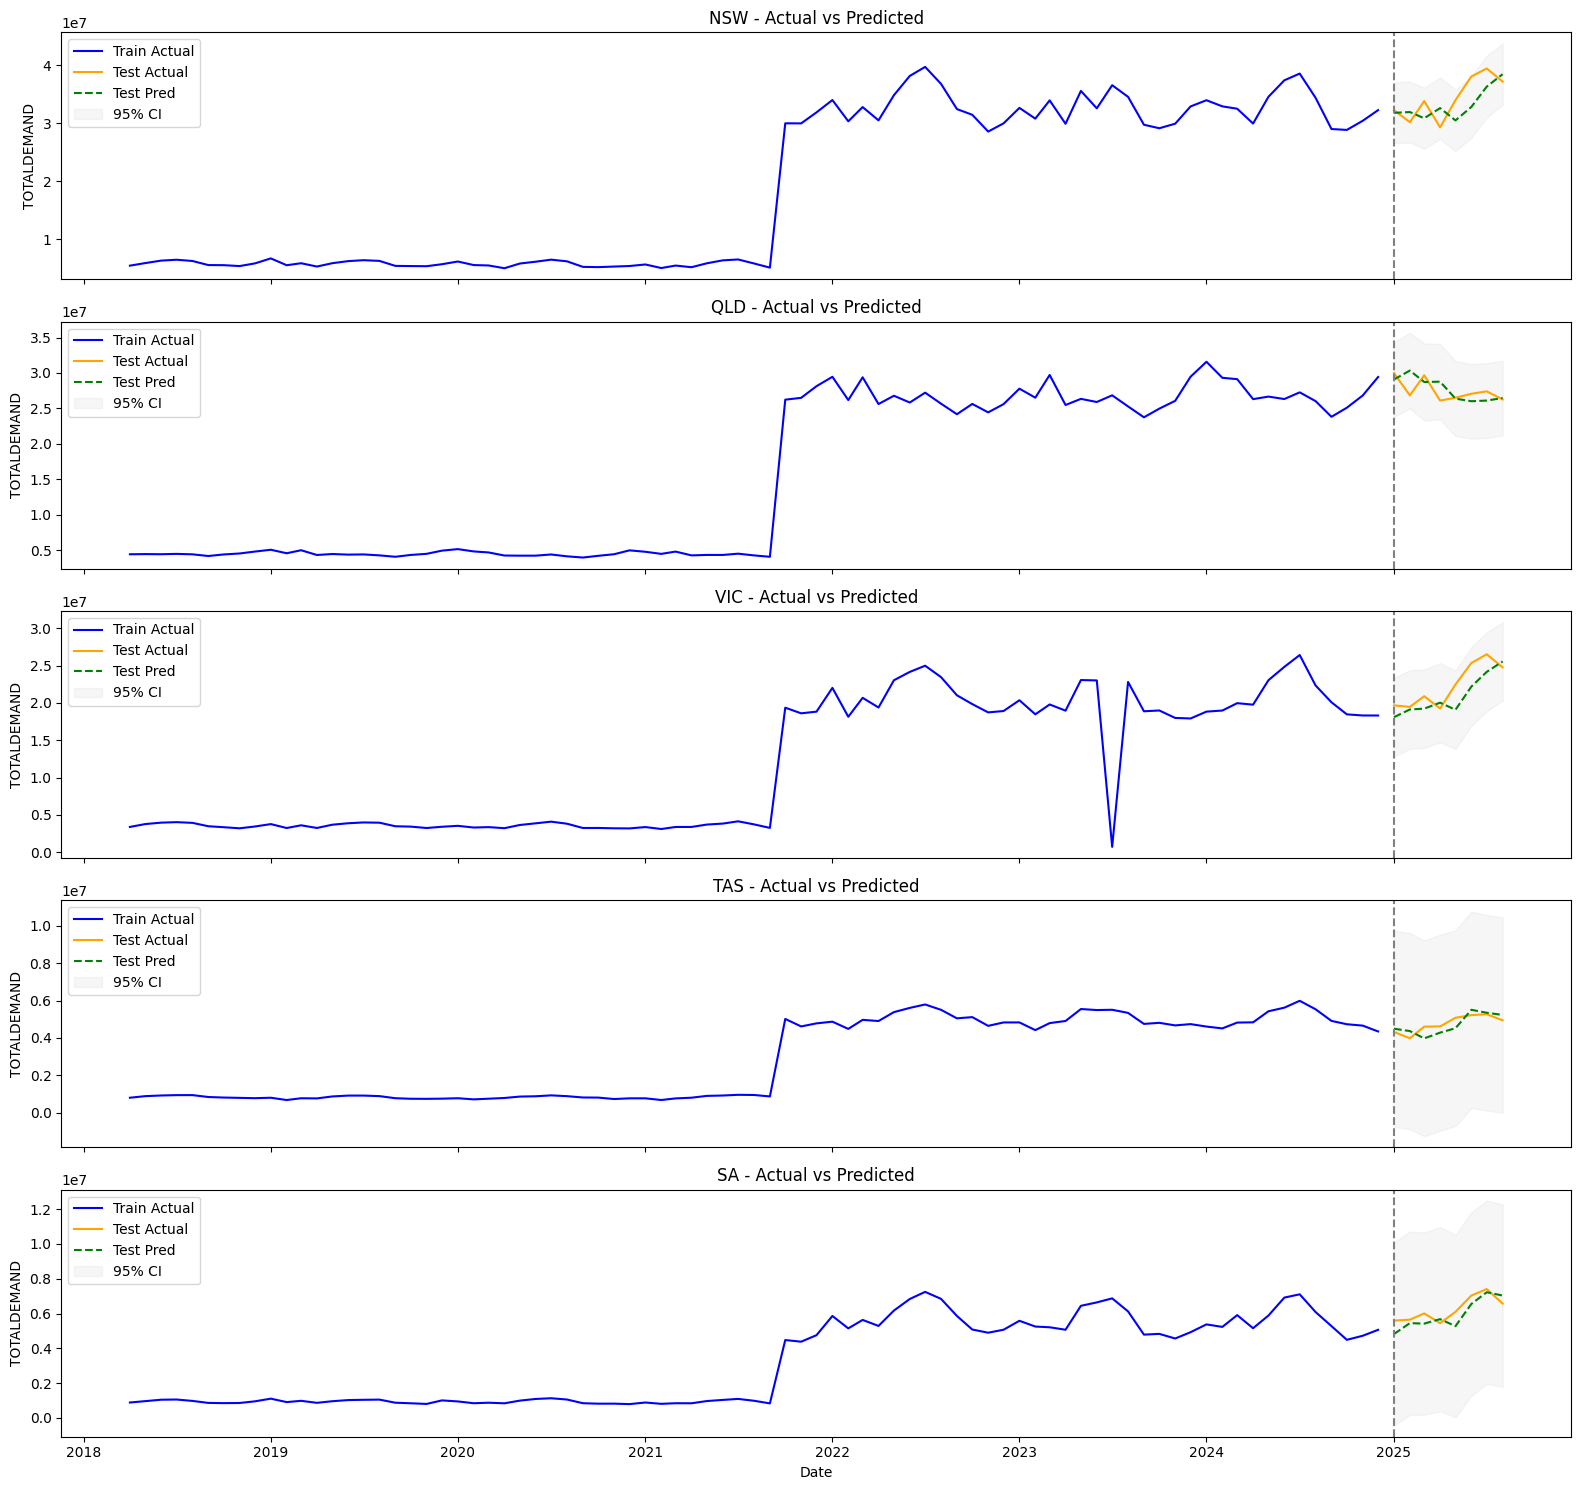

In [73]:
regions = df_all["REGION"].unique()

fig, axes = plt.subplots(len(regions), 1, figsize=(16, 3*len(regions)), sharex=True)

for i, region in enumerate(regions):
    ax = axes[i]
    idx_train = train_df["REGION"] == region
    idx_test = test_df["REGION"] == region

    # Actuals
    ax.plot(y_train_true[idx_train].index, y_train_true[idx_train],
             label="Train Actual", color="blue")
    ax.plot(y_test_true[idx_test].index, y_test_true[idx_test],
             label="Test Actual", color="orange")

    # Predictions
    ax.plot(ci_df.loc[idx_test].index, ci_df.loc[idx_test, "pred"],
             linestyle="--", color="green", label="Test Pred")

    # Confidence interval shading
    ax.fill_between(ci_df.loc[idx_test].index,
                    ci_df.loc[idx_test, "lower"],
                    ci_df.loc[idx_test, "upper"],
                    color="lightgray", alpha=0.2, label="95% CI")

    # Train/test split line
    ax.axvline(test_df.index.min(), color="gray", linestyle="dashed")

    ax.set_title(f"{region} - Actual vs Predicted")
    ax.set_ylabel("TOTALDEMAND")
    ax.legend(loc='upper left')

plt.xlabel("Date")
plt.tight_layout()
plt.show()
